In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_roi_t1_native_k5_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 304)
(657450, 8)
validation
(74368, 304)
(74368, 8)
test
(91684, 304)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 304)]             0         


 dense (Dense)               (None, 1024)              312320    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1002376 (3.82 MB)


Trainable params: 1002376 (3.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:37 - loss: 1.8343 - STD: 0.0769 - MAE: 0.2051

 5/66 [=>............................] - ETA: 0s - loss: 1.4700 - STD: 0.1632 - MAE: 0.1597  

 9/66 [===>..........................] - ETA: 0s - loss: 1.4227 - STD: 0.1907 - MAE: 0.1478

13/66 [====>.........................] - ETA: 0s - loss: 1.3962 - STD: 0.1923 - MAE: 0.1466

17/66 [======>.......................] - ETA: 0s - loss: 1.3782 - STD: 0.1916 - MAE: 0.1465

21/66 [========>.....................] - ETA: 0s - loss: 1.3664 - STD: 0.1922 - MAE: 0.1460

25/66 [==========>...................] - ETA: 0s - loss: 1.3575 - STD: 0.1931 - MAE: 0.1454

29/66 [============>.................] - ETA: 0s - loss: 1.3515 - STD: 0.1928 - MAE: 0.1455

33/66 [==============>...............] - ETA: 0s - loss: 1.3472 - STD: 0.1925 - MAE: 0.1455

37/66 [===============>..............] - ETA: 0s - loss: 1.3440 - STD: 0.1927 - MAE: 0.1454

41/66 [=================>............] - ETA: 0s - loss: 1.3409 - STD: 0.1925 - MAE: 0.1455

45/66 [===================>..........] - ETA: 0s - loss: 1.3376 - STD: 0.1920 - MAE: 0.1456

49/66 [=====================>........] - ETA: 0s - loss: 1.3360 - STD: 0.1919 - MAE: 0.1456

52/66 [======================>.......] - ETA: 0s - loss: 1.3344 - STD: 0.1919 - MAE: 0.1455

56/66 [========================>.....] - ETA: 0s - loss: 1.3323 - STD: 0.1921 - MAE: 0.1454

60/66 [==========================>...] - ETA: 0s - loss: 1.3312 - STD: 0.1922 - MAE: 0.1454

64/66 [============================>.] - ETA: 0s - loss: 1.3295 - STD: 0.1921 - MAE: 0.1454

66/66 [==============================] - 4s 40ms/step - loss: 1.3291 - STD: 0.1921 - MAE: 0.1454 - val_loss: 1.2443 - val_STD: 0.1916 - val_MAE: 0.1420


Epoch 2/10000


 1/66 [..............................] - ETA: 2s - loss: 1.3171 - STD: 0.1915 - MAE: 0.1457

 5/66 [=>............................] - ETA: 0s - loss: 1.3128 - STD: 0.1916 - MAE: 0.1454

 9/66 [===>..........................] - ETA: 0s - loss: 1.3124 - STD: 0.1913 - MAE: 0.1455

13/66 [====>.........................] - ETA: 0s - loss: 1.3135 - STD: 0.1910 - MAE: 0.1457

17/66 [======>.......................] - ETA: 0s - loss: 1.3102 - STD: 0.1910 - MAE: 0.1455

21/66 [========>.....................] - ETA: 0s - loss: 1.3107 - STD: 0.1915 - MAE: 0.1453

25/66 [==========>...................] - ETA: 0s - loss: 1.3111 - STD: 0.1915 - MAE: 0.1454

29/66 [============>.................] - ETA: 0s - loss: 1.3109 - STD: 0.1912 - MAE: 0.1455

33/66 [==============>...............] - ETA: 0s - loss: 1.3093 - STD: 0.1914 - MAE: 0.1453

37/66 [===============>..............] - ETA: 0s - loss: 1.3085 - STD: 0.1914 - MAE: 0.1453

41/66 [=================>............] - ETA: 0s - loss: 1.3079 - STD: 0.1915 - MAE: 0.1452

45/66 [===================>..........] - ETA: 0s - loss: 1.3069 - STD: 0.1916 - MAE: 0.1451

49/66 [=====================>........] - ETA: 0s - loss: 1.3056 - STD: 0.1917 - MAE: 0.1450

53/66 [=======================>......] - ETA: 0s - loss: 1.3043 - STD: 0.1917 - MAE: 0.1449

57/66 [========================>.....] - ETA: 0s - loss: 1.3031 - STD: 0.1918 - MAE: 0.1448

61/66 [==========================>...] - ETA: 0s - loss: 1.3018 - STD: 0.1917 - MAE: 0.1447

65/66 [============================>.] - ETA: 0s - loss: 1.2999 - STD: 0.1919 - MAE: 0.1446

66/66 [==============================] - 1s 16ms/step - loss: 1.2996 - STD: 0.1918 - MAE: 0.1446 - val_loss: 1.2036 - val_STD: 0.2007 - val_MAE: 0.1362


Epoch 3/10000


 1/66 [..............................] - ETA: 2s - loss: 1.2697 - STD: 0.1938 - MAE: 0.1421

 5/66 [=>............................] - ETA: 0s - loss: 1.2739 - STD: 0.1955 - MAE: 0.1417

 9/66 [===>..........................] - ETA: 0s - loss: 1.2702 - STD: 0.1962 - MAE: 0.1413

13/66 [====>.........................] - ETA: 0s - loss: 1.2690 - STD: 0.1956 - MAE: 0.1415

17/66 [======>.......................] - ETA: 0s - loss: 1.2685 - STD: 0.1958 - MAE: 0.1414

21/66 [========>.....................] - ETA: 0s - loss: 1.2670 - STD: 0.1960 - MAE: 0.1412

25/66 [==========>...................] - ETA: 0s - loss: 1.2666 - STD: 0.1962 - MAE: 0.1412

29/66 [============>.................] - ETA: 0s - loss: 1.2658 - STD: 0.1963 - MAE: 0.1411

33/66 [==============>...............] - ETA: 0s - loss: 1.2651 - STD: 0.1965 - MAE: 0.1410

37/66 [===============>..............] - ETA: 0s - loss: 1.2640 - STD: 0.1967 - MAE: 0.1409

41/66 [=================>............] - ETA: 0s - loss: 1.2633 - STD: 0.1967 - MAE: 0.1408

45/66 [===================>..........] - ETA: 0s - loss: 1.2610 - STD: 0.1970 - MAE: 0.1406

49/66 [=====================>........] - ETA: 0s - loss: 1.2593 - STD: 0.1971 - MAE: 0.1405

53/66 [=======================>......] - ETA: 0s - loss: 1.2586 - STD: 0.1972 - MAE: 0.1404

57/66 [========================>.....] - ETA: 0s - loss: 1.2568 - STD: 0.1974 - MAE: 0.1403

61/66 [==========================>...] - ETA: 0s - loss: 1.2550 - STD: 0.1975 - MAE: 0.1402

65/66 [============================>.] - ETA: 0s - loss: 1.2531 - STD: 0.1977 - MAE: 0.1401

66/66 [==============================] - 1s 16ms/step - loss: 1.2529 - STD: 0.1977 - MAE: 0.1401 - val_loss: 1.1507 - val_STD: 0.2062 - val_MAE: 0.1316


Epoch 4/10000


 1/66 [..............................] - ETA: 1s - loss: 1.2313 - STD: 0.1960 - MAE: 0.1403

 5/66 [=>............................] - ETA: 0s - loss: 1.2120 - STD: 0.2000 - MAE: 0.1379

 9/66 [===>..........................] - ETA: 0s - loss: 1.2134 - STD: 0.2005 - MAE: 0.1377

13/66 [====>.........................] - ETA: 0s - loss: 1.2126 - STD: 0.1999 - MAE: 0.1379

17/66 [======>.......................] - ETA: 0s - loss: 1.2096 - STD: 0.1995 - MAE: 0.1380

21/66 [========>.....................] - ETA: 0s - loss: 1.2078 - STD: 0.1996 - MAE: 0.1379

25/66 [==========>...................] - ETA: 0s - loss: 1.2052 - STD: 0.2002 - MAE: 0.1376

29/66 [============>.................] - ETA: 0s - loss: 1.2033 - STD: 0.2005 - MAE: 0.1374

33/66 [==============>...............] - ETA: 0s - loss: 1.2010 - STD: 0.2006 - MAE: 0.1373

37/66 [===============>..............] - ETA: 0s - loss: 1.1984 - STD: 0.2010 - MAE: 0.1370

41/66 [=================>............] - ETA: 0s - loss: 1.1972 - STD: 0.2012 - MAE: 0.1369

45/66 [===================>..........] - ETA: 0s - loss: 1.1966 - STD: 0.2015 - MAE: 0.1368

49/66 [=====================>........] - ETA: 0s - loss: 1.1950 - STD: 0.2016 - MAE: 0.1366

53/66 [=======================>......] - ETA: 0s - loss: 1.1943 - STD: 0.2016 - MAE: 0.1367

57/66 [========================>.....] - ETA: 0s - loss: 1.1934 - STD: 0.2016 - MAE: 0.1366

61/66 [==========================>...] - ETA: 0s - loss: 1.1923 - STD: 0.2018 - MAE: 0.1365

65/66 [============================>.] - ETA: 0s - loss: 1.1919 - STD: 0.2019 - MAE: 0.1365

66/66 [==============================] - 1s 16ms/step - loss: 1.1915 - STD: 0.2019 - MAE: 0.1365 - val_loss: 1.1012 - val_STD: 0.2173 - val_MAE: 0.1253


Epoch 5/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1789 - STD: 0.2048 - MAE: 0.1351

 5/66 [=>............................] - ETA: 0s - loss: 1.1739 - STD: 0.2049 - MAE: 0.1348

 9/66 [===>..........................] - ETA: 0s - loss: 1.1733 - STD: 0.2043 - MAE: 0.1350

13/66 [====>.........................] - ETA: 0s - loss: 1.1729 - STD: 0.2038 - MAE: 0.1352

17/66 [======>.......................] - ETA: 0s - loss: 1.1688 - STD: 0.2040 - MAE: 0.1350

21/66 [========>.....................] - ETA: 0s - loss: 1.1675 - STD: 0.2042 - MAE: 0.1349

25/66 [==========>...................] - ETA: 0s - loss: 1.1660 - STD: 0.2044 - MAE: 0.1347

29/66 [============>.................] - ETA: 0s - loss: 1.1667 - STD: 0.2044 - MAE: 0.1348

33/66 [==============>...............] - ETA: 0s - loss: 1.1656 - STD: 0.2046 - MAE: 0.1347

37/66 [===============>..............] - ETA: 0s - loss: 1.1654 - STD: 0.2045 - MAE: 0.1347

41/66 [=================>............] - ETA: 0s - loss: 1.1655 - STD: 0.2045 - MAE: 0.1347

45/66 [===================>..........] - ETA: 0s - loss: 1.1644 - STD: 0.2046 - MAE: 0.1347

49/66 [=====================>........] - ETA: 0s - loss: 1.1646 - STD: 0.2046 - MAE: 0.1347

53/66 [=======================>......] - ETA: 0s - loss: 1.1647 - STD: 0.2046 - MAE: 0.1347

57/66 [========================>.....] - ETA: 0s - loss: 1.1648 - STD: 0.2046 - MAE: 0.1347

61/66 [==========================>...] - ETA: 0s - loss: 1.1636 - STD: 0.2048 - MAE: 0.1346

65/66 [============================>.] - ETA: 0s - loss: 1.1630 - STD: 0.2048 - MAE: 0.1345

66/66 [==============================] - 1s 16ms/step - loss: 1.1627 - STD: 0.2049 - MAE: 0.1345 - val_loss: 1.0822 - val_STD: 0.2133 - val_MAE: 0.1265


Epoch 6/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1265 - STD: 0.2032 - MAE: 0.1334

 5/66 [=>............................] - ETA: 0s - loss: 1.1489 - STD: 0.2051 - MAE: 0.1338

 9/66 [===>..........................] - ETA: 0s - loss: 1.1510 - STD: 0.2052 - MAE: 0.1339

13/66 [====>.........................] - ETA: 0s - loss: 1.1519 - STD: 0.2056 - MAE: 0.1338

17/66 [======>.......................] - ETA: 0s - loss: 1.1531 - STD: 0.2053 - MAE: 0.1340

21/66 [========>.....................] - ETA: 0s - loss: 1.1543 - STD: 0.2051 - MAE: 0.1342

25/66 [==========>...................] - ETA: 0s - loss: 1.1536 - STD: 0.2052 - MAE: 0.1341

29/66 [============>.................] - ETA: 0s - loss: 1.1520 - STD: 0.2053 - MAE: 0.1340

33/66 [==============>...............] - ETA: 0s - loss: 1.1511 - STD: 0.2055 - MAE: 0.1339

37/66 [===============>..............] - ETA: 0s - loss: 1.1509 - STD: 0.2056 - MAE: 0.1338

41/66 [=================>............] - ETA: 0s - loss: 1.1509 - STD: 0.2057 - MAE: 0.1338

45/66 [===================>..........] - ETA: 0s - loss: 1.1509 - STD: 0.2056 - MAE: 0.1338

49/66 [=====================>........] - ETA: 0s - loss: 1.1515 - STD: 0.2055 - MAE: 0.1339

53/66 [=======================>......] - ETA: 0s - loss: 1.1512 - STD: 0.2054 - MAE: 0.1340

57/66 [========================>.....] - ETA: 0s - loss: 1.1507 - STD: 0.2055 - MAE: 0.1339

61/66 [==========================>...] - ETA: 0s - loss: 1.1494 - STD: 0.2058 - MAE: 0.1338

65/66 [============================>.] - ETA: 0s - loss: 1.1480 - STD: 0.2058 - MAE: 0.1337

66/66 [==============================] - 1s 16ms/step - loss: 1.1477 - STD: 0.2059 - MAE: 0.1336 - val_loss: 1.0763 - val_STD: 0.2097 - val_MAE: 0.1278


Epoch 7/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1427 - STD: 0.2002 - MAE: 0.1359

 5/66 [=>............................] - ETA: 0s - loss: 1.1367 - STD: 0.2060 - MAE: 0.1331

 9/66 [===>..........................] - ETA: 0s - loss: 1.1401 - STD: 0.2058 - MAE: 0.1335

13/66 [====>.........................] - ETA: 0s - loss: 1.1422 - STD: 0.2056 - MAE: 0.1337

17/66 [======>.......................] - ETA: 0s - loss: 1.1411 - STD: 0.2056 - MAE: 0.1336

21/66 [========>.....................] - ETA: 0s - loss: 1.1400 - STD: 0.2056 - MAE: 0.1336

25/66 [==========>...................] - ETA: 0s - loss: 1.1386 - STD: 0.2060 - MAE: 0.1334

29/66 [============>.................] - ETA: 0s - loss: 1.1375 - STD: 0.2061 - MAE: 0.1333

33/66 [==============>...............] - ETA: 0s - loss: 1.1374 - STD: 0.2063 - MAE: 0.1332

37/66 [===============>..............] - ETA: 0s - loss: 1.1371 - STD: 0.2063 - MAE: 0.1331

41/66 [=================>............] - ETA: 0s - loss: 1.1367 - STD: 0.2062 - MAE: 0.1331

45/66 [===================>..........] - ETA: 0s - loss: 1.1363 - STD: 0.2063 - MAE: 0.1331

49/66 [=====================>........] - ETA: 0s - loss: 1.1362 - STD: 0.2063 - MAE: 0.1331

53/66 [=======================>......] - ETA: 0s - loss: 1.1354 - STD: 0.2065 - MAE: 0.1330

57/66 [========================>.....] - ETA: 0s - loss: 1.1348 - STD: 0.2067 - MAE: 0.1329

61/66 [==========================>...] - ETA: 0s - loss: 1.1345 - STD: 0.2065 - MAE: 0.1330

65/66 [============================>.] - ETA: 0s - loss: 1.1335 - STD: 0.2065 - MAE: 0.1329

66/66 [==============================] - 1s 16ms/step - loss: 1.1334 - STD: 0.2066 - MAE: 0.1329 - val_loss: 1.0738 - val_STD: 0.2149 - val_MAE: 0.1254


Epoch 8/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1103 - STD: 0.2062 - MAE: 0.1318

 5/66 [=>............................] - ETA: 0s - loss: 1.1234 - STD: 0.2066 - MAE: 0.1325

 9/66 [===>..........................] - ETA: 0s - loss: 1.1222 - STD: 0.2068 - MAE: 0.1324

13/66 [====>.........................] - ETA: 0s - loss: 1.1214 - STD: 0.2070 - MAE: 0.1323

17/66 [======>.......................] - ETA: 0s - loss: 1.1208 - STD: 0.2069 - MAE: 0.1323

21/66 [========>.....................] - ETA: 0s - loss: 1.1199 - STD: 0.2070 - MAE: 0.1322

25/66 [==========>...................] - ETA: 0s - loss: 1.1202 - STD: 0.2070 - MAE: 0.1322

29/66 [============>.................] - ETA: 0s - loss: 1.1194 - STD: 0.2071 - MAE: 0.1321

33/66 [==============>...............] - ETA: 0s - loss: 1.1181 - STD: 0.2074 - MAE: 0.1319

37/66 [===============>..............] - ETA: 0s - loss: 1.1182 - STD: 0.2074 - MAE: 0.1319

41/66 [=================>............] - ETA: 0s - loss: 1.1189 - STD: 0.2074 - MAE: 0.1319

45/66 [===================>..........] - ETA: 0s - loss: 1.1183 - STD: 0.2074 - MAE: 0.1319

49/66 [=====================>........] - ETA: 0s - loss: 1.1183 - STD: 0.2074 - MAE: 0.1319

53/66 [=======================>......] - ETA: 0s - loss: 1.1179 - STD: 0.2075 - MAE: 0.1319

57/66 [========================>.....] - ETA: 0s - loss: 1.1174 - STD: 0.2077 - MAE: 0.1318

61/66 [==========================>...] - ETA: 0s - loss: 1.1169 - STD: 0.2078 - MAE: 0.1317

65/66 [============================>.] - ETA: 0s - loss: 1.1165 - STD: 0.2080 - MAE: 0.1316

66/66 [==============================] - 1s 16ms/step - loss: 1.1160 - STD: 0.2078 - MAE: 0.1317 - val_loss: 1.0782 - val_STD: 0.2161 - val_MAE: 0.1247


Epoch 9/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0894 - STD: 0.2099 - MAE: 0.1294

 5/66 [=>............................] - ETA: 0s - loss: 1.0988 - STD: 0.2090 - MAE: 0.1304

 9/66 [===>..........................] - ETA: 0s - loss: 1.0971 - STD: 0.2100 - MAE: 0.1298

13/66 [====>.........................] - ETA: 0s - loss: 1.1016 - STD: 0.2096 - MAE: 0.1303

17/66 [======>.......................] - ETA: 0s - loss: 1.1010 - STD: 0.2097 - MAE: 0.1303

21/66 [========>.....................] - ETA: 0s - loss: 1.1031 - STD: 0.2095 - MAE: 0.1304

25/66 [==========>...................] - ETA: 0s - loss: 1.1031 - STD: 0.2095 - MAE: 0.1304

29/66 [============>.................] - ETA: 0s - loss: 1.1015 - STD: 0.2096 - MAE: 0.1302

33/66 [==============>...............] - ETA: 0s - loss: 1.1013 - STD: 0.2097 - MAE: 0.1302

37/66 [===============>..............] - ETA: 0s - loss: 1.1001 - STD: 0.2098 - MAE: 0.1301

41/66 [=================>............] - ETA: 0s - loss: 1.1000 - STD: 0.2097 - MAE: 0.1301

45/66 [===================>..........] - ETA: 0s - loss: 1.1000 - STD: 0.2096 - MAE: 0.1302

49/66 [=====================>........] - ETA: 0s - loss: 1.0989 - STD: 0.2098 - MAE: 0.1300

53/66 [=======================>......] - ETA: 0s - loss: 1.0988 - STD: 0.2100 - MAE: 0.1299

57/66 [========================>.....] - ETA: 0s - loss: 1.0983 - STD: 0.2100 - MAE: 0.1299

61/66 [==========================>...] - ETA: 0s - loss: 1.0980 - STD: 0.2099 - MAE: 0.1299

65/66 [============================>.] - ETA: 0s - loss: 1.0975 - STD: 0.2100 - MAE: 0.1298

66/66 [==============================] - 1s 15ms/step - loss: 1.0977 - STD: 0.2101 - MAE: 0.1299 - val_loss: 1.0833 - val_STD: 0.2179 - val_MAE: 0.1240


Epoch 10/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0920 - STD: 0.2115 - MAE: 0.1289

 5/66 [=>............................] - ETA: 0s - loss: 1.0929 - STD: 0.2116 - MAE: 0.1290

 9/66 [===>..........................] - ETA: 0s - loss: 1.0921 - STD: 0.2114 - MAE: 0.1290

13/66 [====>.........................] - ETA: 0s - loss: 1.0885 - STD: 0.2116 - MAE: 0.1287

17/66 [======>.......................] - ETA: 0s - loss: 1.0900 - STD: 0.2111 - MAE: 0.1291

21/66 [========>.....................] - ETA: 0s - loss: 1.0881 - STD: 0.2116 - MAE: 0.1287

25/66 [==========>...................] - ETA: 0s - loss: 1.0879 - STD: 0.2114 - MAE: 0.1288

29/66 [============>.................] - ETA: 0s - loss: 1.0879 - STD: 0.2113 - MAE: 0.1289

33/66 [==============>...............] - ETA: 0s - loss: 1.0887 - STD: 0.2111 - MAE: 0.1290

37/66 [===============>..............] - ETA: 0s - loss: 1.0890 - STD: 0.2109 - MAE: 0.1291

41/66 [=================>............] - ETA: 0s - loss: 1.0886 - STD: 0.2110 - MAE: 0.1291

45/66 [===================>..........] - ETA: 0s - loss: 1.0883 - STD: 0.2112 - MAE: 0.1289

49/66 [=====================>........] - ETA: 0s - loss: 1.0874 - STD: 0.2113 - MAE: 0.1288

53/66 [=======================>......] - ETA: 0s - loss: 1.0871 - STD: 0.2114 - MAE: 0.1288

57/66 [========================>.....] - ETA: 0s - loss: 1.0870 - STD: 0.2114 - MAE: 0.1288

61/66 [==========================>...] - ETA: 0s - loss: 1.0870 - STD: 0.2113 - MAE: 0.1288

65/66 [============================>.] - ETA: 0s - loss: 1.0865 - STD: 0.2114 - MAE: 0.1288

66/66 [==============================] - 1s 16ms/step - loss: 1.0864 - STD: 0.2114 - MAE: 0.1288 - val_loss: 1.0724 - val_STD: 0.2133 - val_MAE: 0.1256


Epoch 11/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0799 - STD: 0.2078 - MAE: 0.1303

 5/66 [=>............................] - ETA: 0s - loss: 1.0873 - STD: 0.2108 - MAE: 0.1293

 9/66 [===>..........................] - ETA: 0s - loss: 1.0873 - STD: 0.2109 - MAE: 0.1292

13/66 [====>.........................] - ETA: 0s - loss: 1.0866 - STD: 0.2115 - MAE: 0.1289

17/66 [======>.......................] - ETA: 0s - loss: 1.0837 - STD: 0.2120 - MAE: 0.1285

21/66 [========>.....................] - ETA: 0s - loss: 1.0822 - STD: 0.2119 - MAE: 0.1284

25/66 [==========>...................] - ETA: 0s - loss: 1.0817 - STD: 0.2118 - MAE: 0.1284

29/66 [============>.................] - ETA: 0s - loss: 1.0811 - STD: 0.2119 - MAE: 0.1283

33/66 [==============>...............] - ETA: 0s - loss: 1.0809 - STD: 0.2119 - MAE: 0.1283

37/66 [===============>..............] - ETA: 0s - loss: 1.0807 - STD: 0.2121 - MAE: 0.1282

41/66 [=================>............] - ETA: 0s - loss: 1.0806 - STD: 0.2121 - MAE: 0.1282

45/66 [===================>..........] - ETA: 0s - loss: 1.0806 - STD: 0.2122 - MAE: 0.1282

49/66 [=====================>........] - ETA: 0s - loss: 1.0808 - STD: 0.2123 - MAE: 0.1282

53/66 [=======================>......] - ETA: 0s - loss: 1.0812 - STD: 0.2123 - MAE: 0.1282

57/66 [========================>.....] - ETA: 0s - loss: 1.0819 - STD: 0.2123 - MAE: 0.1282

61/66 [==========================>...] - ETA: 0s - loss: 1.0824 - STD: 0.2123 - MAE: 0.1282

65/66 [============================>.] - ETA: 0s - loss: 1.0821 - STD: 0.2123 - MAE: 0.1282

66/66 [==============================] - 1s 16ms/step - loss: 1.0823 - STD: 0.2123 - MAE: 0.1282 - val_loss: 1.0692 - val_STD: 0.2169 - val_MAE: 0.1239


Epoch 12/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0736 - STD: 0.2143 - MAE: 0.1272

 5/66 [=>............................] - ETA: 0s - loss: 1.0810 - STD: 0.2127 - MAE: 0.1281

 9/66 [===>..........................] - ETA: 0s - loss: 1.0816 - STD: 0.2124 - MAE: 0.1283

13/66 [====>.........................] - ETA: 0s - loss: 1.0820 - STD: 0.2123 - MAE: 0.1283

17/66 [======>.......................] - ETA: 0s - loss: 1.0801 - STD: 0.2121 - MAE: 0.1282

21/66 [========>.....................] - ETA: 0s - loss: 1.0792 - STD: 0.2125 - MAE: 0.1281

25/66 [==========>...................] - ETA: 0s - loss: 1.0801 - STD: 0.2124 - MAE: 0.1281

29/66 [============>.................] - ETA: 0s - loss: 1.0788 - STD: 0.2124 - MAE: 0.1281

33/66 [==============>...............] - ETA: 0s - loss: 1.0780 - STD: 0.2124 - MAE: 0.1281

37/66 [===============>..............] - ETA: 0s - loss: 1.0779 - STD: 0.2123 - MAE: 0.1281

41/66 [=================>............] - ETA: 0s - loss: 1.0766 - STD: 0.2124 - MAE: 0.1280

45/66 [===================>..........] - ETA: 0s - loss: 1.0753 - STD: 0.2126 - MAE: 0.1279

49/66 [=====================>........] - ETA: 0s - loss: 1.0748 - STD: 0.2127 - MAE: 0.1278

53/66 [=======================>......] - ETA: 0s - loss: 1.0746 - STD: 0.2127 - MAE: 0.1277

57/66 [========================>.....] - ETA: 0s - loss: 1.0742 - STD: 0.2127 - MAE: 0.1277

61/66 [==========================>...] - ETA: 0s - loss: 1.0729 - STD: 0.2129 - MAE: 0.1276

65/66 [============================>.] - ETA: 0s - loss: 1.0731 - STD: 0.2129 - MAE: 0.1276

66/66 [==============================] - 1s 16ms/step - loss: 1.0734 - STD: 0.2129 - MAE: 0.1276 - val_loss: 1.0666 - val_STD: 0.2153 - val_MAE: 0.1245


Epoch 13/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0806 - STD: 0.2115 - MAE: 0.1289

 5/66 [=>............................] - ETA: 0s - loss: 1.0741 - STD: 0.2131 - MAE: 0.1276

 9/66 [===>..........................] - ETA: 0s - loss: 1.0771 - STD: 0.2122 - MAE: 0.1283

13/66 [====>.........................] - ETA: 0s - loss: 1.0751 - STD: 0.2130 - MAE: 0.1277

17/66 [======>.......................] - ETA: 0s - loss: 1.0756 - STD: 0.2127 - MAE: 0.1279

21/66 [========>.....................] - ETA: 0s - loss: 1.0759 - STD: 0.2125 - MAE: 0.1280

25/66 [==========>...................] - ETA: 0s - loss: 1.0743 - STD: 0.2130 - MAE: 0.1277

29/66 [============>.................] - ETA: 0s - loss: 1.0742 - STD: 0.2130 - MAE: 0.1277

33/66 [==============>...............] - ETA: 0s - loss: 1.0731 - STD: 0.2132 - MAE: 0.1275

37/66 [===============>..............] - ETA: 0s - loss: 1.0729 - STD: 0.2134 - MAE: 0.1274

41/66 [=================>............] - ETA: 0s - loss: 1.0731 - STD: 0.2132 - MAE: 0.1275

45/66 [===================>..........] - ETA: 0s - loss: 1.0726 - STD: 0.2131 - MAE: 0.1276

49/66 [=====================>........] - ETA: 0s - loss: 1.0717 - STD: 0.2132 - MAE: 0.1275

53/66 [=======================>......] - ETA: 0s - loss: 1.0711 - STD: 0.2131 - MAE: 0.1275

57/66 [========================>.....] - ETA: 0s - loss: 1.0699 - STD: 0.2133 - MAE: 0.1274

61/66 [==========================>...] - ETA: 0s - loss: 1.0697 - STD: 0.2134 - MAE: 0.1273

65/66 [============================>.] - ETA: 0s - loss: 1.0693 - STD: 0.2134 - MAE: 0.1272

66/66 [==============================] - 1s 15ms/step - loss: 1.0693 - STD: 0.2134 - MAE: 0.1273 - val_loss: 1.0643 - val_STD: 0.2167 - val_MAE: 0.1239


Epoch 14/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0565 - STD: 0.2129 - MAE: 0.1266

 5/66 [=>............................] - ETA: 0s - loss: 1.0645 - STD: 0.2137 - MAE: 0.1269

 9/66 [===>..........................] - ETA: 0s - loss: 1.0663 - STD: 0.2136 - MAE: 0.1271

13/66 [====>.........................] - ETA: 0s - loss: 1.0635 - STD: 0.2141 - MAE: 0.1268

17/66 [======>.......................] - ETA: 0s - loss: 1.0640 - STD: 0.2140 - MAE: 0.1268

21/66 [========>.....................] - ETA: 0s - loss: 1.0649 - STD: 0.2137 - MAE: 0.1270

25/66 [==========>...................] - ETA: 0s - loss: 1.0650 - STD: 0.2139 - MAE: 0.1269

29/66 [============>.................] - ETA: 0s - loss: 1.0638 - STD: 0.2140 - MAE: 0.1268

33/66 [==============>...............] - ETA: 0s - loss: 1.0638 - STD: 0.2139 - MAE: 0.1268

37/66 [===============>..............] - ETA: 0s - loss: 1.0637 - STD: 0.2140 - MAE: 0.1268

41/66 [=================>............] - ETA: 0s - loss: 1.0639 - STD: 0.2139 - MAE: 0.1269

45/66 [===================>..........] - ETA: 0s - loss: 1.0630 - STD: 0.2141 - MAE: 0.1268

49/66 [=====================>........] - ETA: 0s - loss: 1.0625 - STD: 0.2141 - MAE: 0.1267

53/66 [=======================>......] - ETA: 0s - loss: 1.0624 - STD: 0.2141 - MAE: 0.1267

57/66 [========================>.....] - ETA: 0s - loss: 1.0621 - STD: 0.2141 - MAE: 0.1267

61/66 [==========================>...] - ETA: 0s - loss: 1.0620 - STD: 0.2142 - MAE: 0.1266

65/66 [============================>.] - ETA: 0s - loss: 1.0617 - STD: 0.2141 - MAE: 0.1266

66/66 [==============================] - 1s 16ms/step - loss: 1.0614 - STD: 0.2141 - MAE: 0.1266 - val_loss: 1.0637 - val_STD: 0.2257 - val_MAE: 0.1197


Epoch 15/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0572 - STD: 0.2230 - MAE: 0.1227

 5/66 [=>............................] - ETA: 0s - loss: 1.0597 - STD: 0.2155 - MAE: 0.1261

 9/66 [===>..........................] - ETA: 0s - loss: 1.0605 - STD: 0.2139 - MAE: 0.1268

13/66 [====>.........................] - ETA: 0s - loss: 1.0587 - STD: 0.2146 - MAE: 0.1264

17/66 [======>.......................] - ETA: 0s - loss: 1.0595 - STD: 0.2147 - MAE: 0.1264

21/66 [========>.....................] - ETA: 0s - loss: 1.0585 - STD: 0.2146 - MAE: 0.1263

25/66 [==========>...................] - ETA: 0s - loss: 1.0584 - STD: 0.2146 - MAE: 0.1264

29/66 [============>.................] - ETA: 0s - loss: 1.0570 - STD: 0.2148 - MAE: 0.1262

33/66 [==============>...............] - ETA: 0s - loss: 1.0568 - STD: 0.2150 - MAE: 0.1261

37/66 [===============>..............] - ETA: 0s - loss: 1.0565 - STD: 0.2149 - MAE: 0.1261

41/66 [=================>............] - ETA: 0s - loss: 1.0560 - STD: 0.2149 - MAE: 0.1261

45/66 [===================>..........] - ETA: 0s - loss: 1.0561 - STD: 0.2150 - MAE: 0.1260

49/66 [=====================>........] - ETA: 0s - loss: 1.0570 - STD: 0.2150 - MAE: 0.1261

53/66 [=======================>......] - ETA: 0s - loss: 1.0578 - STD: 0.2148 - MAE: 0.1262

57/66 [========================>.....] - ETA: 0s - loss: 1.0584 - STD: 0.2147 - MAE: 0.1263

61/66 [==========================>...] - ETA: 0s - loss: 1.0585 - STD: 0.2147 - MAE: 0.1263

65/66 [============================>.] - ETA: 0s - loss: 1.0587 - STD: 0.2146 - MAE: 0.1263

66/66 [==============================] - 1s 15ms/step - loss: 1.0586 - STD: 0.2147 - MAE: 0.1263 - val_loss: 1.0645 - val_STD: 0.2178 - val_MAE: 0.1232


Epoch 16/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0701 - STD: 0.2139 - MAE: 0.1274

 5/66 [=>............................] - ETA: 0s - loss: 1.0638 - STD: 0.2137 - MAE: 0.1270

 9/66 [===>..........................] - ETA: 0s - loss: 1.0610 - STD: 0.2139 - MAE: 0.1268

13/66 [====>.........................] - ETA: 0s - loss: 1.0585 - STD: 0.2140 - MAE: 0.1267

17/66 [======>.......................] - ETA: 0s - loss: 1.0553 - STD: 0.2143 - MAE: 0.1263

21/66 [========>.....................] - ETA: 0s - loss: 1.0530 - STD: 0.2147 - MAE: 0.1260

25/66 [==========>...................] - ETA: 0s - loss: 1.0536 - STD: 0.2147 - MAE: 0.1260

29/66 [============>.................] - ETA: 0s - loss: 1.0538 - STD: 0.2145 - MAE: 0.1262

33/66 [==============>...............] - ETA: 0s - loss: 1.0540 - STD: 0.2147 - MAE: 0.1261

37/66 [===============>..............] - ETA: 0s - loss: 1.0544 - STD: 0.2147 - MAE: 0.1261

41/66 [=================>............] - ETA: 0s - loss: 1.0541 - STD: 0.2147 - MAE: 0.1261

45/66 [===================>..........] - ETA: 0s - loss: 1.0532 - STD: 0.2147 - MAE: 0.1260

49/66 [=====================>........] - ETA: 0s - loss: 1.0529 - STD: 0.2148 - MAE: 0.1260

53/66 [=======================>......] - ETA: 0s - loss: 1.0529 - STD: 0.2147 - MAE: 0.1260

57/66 [========================>.....] - ETA: 0s - loss: 1.0527 - STD: 0.2148 - MAE: 0.1260

61/66 [==========================>...] - ETA: 0s - loss: 1.0526 - STD: 0.2148 - MAE: 0.1260

65/66 [============================>.] - ETA: 0s - loss: 1.0525 - STD: 0.2149 - MAE: 0.1259

66/66 [==============================] - 1s 16ms/step - loss: 1.0524 - STD: 0.2151 - MAE: 0.1259 - val_loss: 1.0535 - val_STD: 0.2112 - val_MAE: 0.1257


Epoch 17/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0639 - STD: 0.2081 - MAE: 0.1295

 5/66 [=>............................] - ETA: 0s - loss: 1.0568 - STD: 0.2139 - MAE: 0.1267

 9/66 [===>..........................] - ETA: 0s - loss: 1.0553 - STD: 0.2139 - MAE: 0.1267

13/66 [====>.........................] - ETA: 0s - loss: 1.0539 - STD: 0.2140 - MAE: 0.1266

17/66 [======>.......................] - ETA: 0s - loss: 1.0523 - STD: 0.2142 - MAE: 0.1264

21/66 [========>.....................] - ETA: 0s - loss: 1.0538 - STD: 0.2143 - MAE: 0.1264

25/66 [==========>...................] - ETA: 0s - loss: 1.0546 - STD: 0.2143 - MAE: 0.1264

29/66 [============>.................] - ETA: 0s - loss: 1.0533 - STD: 0.2143 - MAE: 0.1264

33/66 [==============>...............] - ETA: 0s - loss: 1.0526 - STD: 0.2146 - MAE: 0.1262

37/66 [===============>..............] - ETA: 0s - loss: 1.0517 - STD: 0.2148 - MAE: 0.1261

41/66 [=================>............] - ETA: 0s - loss: 1.0513 - STD: 0.2149 - MAE: 0.1260

45/66 [===================>..........] - ETA: 0s - loss: 1.0501 - STD: 0.2151 - MAE: 0.1258

49/66 [=====================>........] - ETA: 0s - loss: 1.0503 - STD: 0.2151 - MAE: 0.1258

53/66 [=======================>......] - ETA: 0s - loss: 1.0504 - STD: 0.2152 - MAE: 0.1258

57/66 [========================>.....] - ETA: 0s - loss: 1.0502 - STD: 0.2154 - MAE: 0.1257

61/66 [==========================>...] - ETA: 0s - loss: 1.0502 - STD: 0.2154 - MAE: 0.1257

65/66 [============================>.] - ETA: 0s - loss: 1.0501 - STD: 0.2154 - MAE: 0.1257

66/66 [==============================] - 1s 16ms/step - loss: 1.0501 - STD: 0.2155 - MAE: 0.1256 - val_loss: 1.0496 - val_STD: 0.2172 - val_MAE: 0.1230


Epoch 18/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0525 - STD: 0.2147 - MAE: 0.1262

 5/66 [=>............................] - ETA: 0s - loss: 1.0614 - STD: 0.2131 - MAE: 0.1274

 9/66 [===>..........................] - ETA: 0s - loss: 1.0594 - STD: 0.2145 - MAE: 0.1267

13/66 [====>.........................] - ETA: 0s - loss: 1.0575 - STD: 0.2149 - MAE: 0.1263

17/66 [======>.......................] - ETA: 0s - loss: 1.0537 - STD: 0.2150 - MAE: 0.1261

21/66 [========>.....................] - ETA: 0s - loss: 1.0524 - STD: 0.2152 - MAE: 0.1259

25/66 [==========>...................] - ETA: 0s - loss: 1.0514 - STD: 0.2155 - MAE: 0.1257

29/66 [============>.................] - ETA: 0s - loss: 1.0520 - STD: 0.2154 - MAE: 0.1258

33/66 [==============>...............] - ETA: 0s - loss: 1.0517 - STD: 0.2155 - MAE: 0.1257

37/66 [===============>..............] - ETA: 0s - loss: 1.0516 - STD: 0.2155 - MAE: 0.1257

41/66 [=================>............] - ETA: 0s - loss: 1.0512 - STD: 0.2155 - MAE: 0.1257

45/66 [===================>..........] - ETA: 0s - loss: 1.0514 - STD: 0.2154 - MAE: 0.1257

49/66 [=====================>........] - ETA: 0s - loss: 1.0504 - STD: 0.2155 - MAE: 0.1256

53/66 [=======================>......] - ETA: 0s - loss: 1.0503 - STD: 0.2156 - MAE: 0.1256

57/66 [========================>.....] - ETA: 0s - loss: 1.0506 - STD: 0.2155 - MAE: 0.1257

61/66 [==========================>...] - ETA: 0s - loss: 1.0505 - STD: 0.2154 - MAE: 0.1257

65/66 [============================>.] - ETA: 0s - loss: 1.0503 - STD: 0.2153 - MAE: 0.1257

66/66 [==============================] - 1s 16ms/step - loss: 1.0500 - STD: 0.2154 - MAE: 0.1257 - val_loss: 1.0497 - val_STD: 0.2210 - val_MAE: 0.1213


Epoch 19/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0552 - STD: 0.2202 - MAE: 0.1239

 5/66 [=>............................] - ETA: 0s - loss: 1.0461 - STD: 0.2159 - MAE: 0.1254

 9/66 [===>..........................] - ETA: 0s - loss: 1.0445 - STD: 0.2159 - MAE: 0.1251

13/66 [====>.........................] - ETA: 0s - loss: 1.0450 - STD: 0.2156 - MAE: 0.1253

17/66 [======>.......................] - ETA: 0s - loss: 1.0442 - STD: 0.2157 - MAE: 0.1253

21/66 [========>.....................] - ETA: 0s - loss: 1.0429 - STD: 0.2159 - MAE: 0.1251

25/66 [==========>...................] - ETA: 0s - loss: 1.0435 - STD: 0.2158 - MAE: 0.1252

29/66 [============>.................] - ETA: 0s - loss: 1.0424 - STD: 0.2157 - MAE: 0.1252

33/66 [==============>...............] - ETA: 0s - loss: 1.0417 - STD: 0.2158 - MAE: 0.1251

37/66 [===============>..............] - ETA: 0s - loss: 1.0426 - STD: 0.2157 - MAE: 0.1252

41/66 [=================>............] - ETA: 0s - loss: 1.0424 - STD: 0.2157 - MAE: 0.1252

45/66 [===================>..........] - ETA: 0s - loss: 1.0428 - STD: 0.2159 - MAE: 0.1251

49/66 [=====================>........] - ETA: 0s - loss: 1.0427 - STD: 0.2158 - MAE: 0.1252

53/66 [=======================>......] - ETA: 0s - loss: 1.0425 - STD: 0.2158 - MAE: 0.1252

57/66 [========================>.....] - ETA: 0s - loss: 1.0425 - STD: 0.2158 - MAE: 0.1252

61/66 [==========================>...] - ETA: 0s - loss: 1.0419 - STD: 0.2158 - MAE: 0.1252

65/66 [============================>.] - ETA: 0s - loss: 1.0415 - STD: 0.2159 - MAE: 0.1251

66/66 [==============================] - 1s 15ms/step - loss: 1.0414 - STD: 0.2159 - MAE: 0.1251 - val_loss: 1.0533 - val_STD: 0.2238 - val_MAE: 0.1201


Epoch 20/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0419 - STD: 0.2215 - MAE: 0.1230

 5/66 [=>............................] - ETA: 0s - loss: 1.0347 - STD: 0.2166 - MAE: 0.1246

 9/66 [===>..........................] - ETA: 0s - loss: 1.0371 - STD: 0.2165 - MAE: 0.1247

13/66 [====>.........................] - ETA: 0s - loss: 1.0382 - STD: 0.2167 - MAE: 0.1247

17/66 [======>.......................] - ETA: 0s - loss: 1.0395 - STD: 0.2165 - MAE: 0.1248

21/66 [========>.....................] - ETA: 0s - loss: 1.0418 - STD: 0.2164 - MAE: 0.1250

25/66 [==========>...................] - ETA: 0s - loss: 1.0417 - STD: 0.2162 - MAE: 0.1250

29/66 [============>.................] - ETA: 0s - loss: 1.0414 - STD: 0.2162 - MAE: 0.1250

33/66 [==============>...............] - ETA: 0s - loss: 1.0408 - STD: 0.2164 - MAE: 0.1249

37/66 [===============>..............] - ETA: 0s - loss: 1.0395 - STD: 0.2165 - MAE: 0.1248

41/66 [=================>............] - ETA: 0s - loss: 1.0393 - STD: 0.2164 - MAE: 0.1248

45/66 [===================>..........] - ETA: 0s - loss: 1.0389 - STD: 0.2164 - MAE: 0.1248

49/66 [=====================>........] - ETA: 0s - loss: 1.0390 - STD: 0.2164 - MAE: 0.1248

53/66 [=======================>......] - ETA: 0s - loss: 1.0386 - STD: 0.2163 - MAE: 0.1248

57/66 [========================>.....] - ETA: 0s - loss: 1.0382 - STD: 0.2164 - MAE: 0.1247

61/66 [==========================>...] - ETA: 0s - loss: 1.0385 - STD: 0.2164 - MAE: 0.1248

65/66 [============================>.] - ETA: 0s - loss: 1.0384 - STD: 0.2164 - MAE: 0.1247

66/66 [==============================] - 1s 16ms/step - loss: 1.0383 - STD: 0.2164 - MAE: 0.1247 - val_loss: 1.0450 - val_STD: 0.2194 - val_MAE: 0.1217


Epoch 21/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0356 - STD: 0.2167 - MAE: 0.1247

 5/66 [=>............................] - ETA: 0s - loss: 1.0419 - STD: 0.2162 - MAE: 0.1251

 9/66 [===>..........................] - ETA: 0s - loss: 1.0376 - STD: 0.2163 - MAE: 0.1248

13/66 [====>.........................] - ETA: 0s - loss: 1.0379 - STD: 0.2164 - MAE: 0.1248

17/66 [======>.......................] - ETA: 0s - loss: 1.0355 - STD: 0.2163 - MAE: 0.1247

21/66 [========>.....................] - ETA: 0s - loss: 1.0331 - STD: 0.2168 - MAE: 0.1244

25/66 [==========>...................] - ETA: 0s - loss: 1.0344 - STD: 0.2168 - MAE: 0.1244

29/66 [============>.................] - ETA: 0s - loss: 1.0345 - STD: 0.2167 - MAE: 0.1245

33/66 [==============>...............] - ETA: 0s - loss: 1.0356 - STD: 0.2169 - MAE: 0.1245

37/66 [===============>..............] - ETA: 0s - loss: 1.0358 - STD: 0.2167 - MAE: 0.1246

41/66 [=================>............] - ETA: 0s - loss: 1.0361 - STD: 0.2167 - MAE: 0.1246

45/66 [===================>..........] - ETA: 0s - loss: 1.0350 - STD: 0.2167 - MAE: 0.1245

49/66 [=====================>........] - ETA: 0s - loss: 1.0350 - STD: 0.2167 - MAE: 0.1245

53/66 [=======================>......] - ETA: 0s - loss: 1.0346 - STD: 0.2167 - MAE: 0.1245

57/66 [========================>.....] - ETA: 0s - loss: 1.0345 - STD: 0.2168 - MAE: 0.1244

61/66 [==========================>...] - ETA: 0s - loss: 1.0341 - STD: 0.2167 - MAE: 0.1244

65/66 [============================>.] - ETA: 0s - loss: 1.0343 - STD: 0.2167 - MAE: 0.1245

66/66 [==============================] - 1s 15ms/step - loss: 1.0344 - STD: 0.2167 - MAE: 0.1245 - val_loss: 1.0472 - val_STD: 0.2205 - val_MAE: 0.1213


Epoch 22/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0377 - STD: 0.2158 - MAE: 0.1253

 5/66 [=>............................] - ETA: 0s - loss: 1.0223 - STD: 0.2180 - MAE: 0.1235

 9/66 [===>..........................] - ETA: 0s - loss: 1.0307 - STD: 0.2174 - MAE: 0.1240

13/66 [====>.........................] - ETA: 0s - loss: 1.0308 - STD: 0.2170 - MAE: 0.1242

17/66 [======>.......................] - ETA: 0s - loss: 1.0311 - STD: 0.2170 - MAE: 0.1242

21/66 [========>.....................] - ETA: 0s - loss: 1.0319 - STD: 0.2169 - MAE: 0.1243

25/66 [==========>...................] - ETA: 0s - loss: 1.0318 - STD: 0.2169 - MAE: 0.1243

29/66 [============>.................] - ETA: 0s - loss: 1.0316 - STD: 0.2170 - MAE: 0.1242

33/66 [==============>...............] - ETA: 0s - loss: 1.0322 - STD: 0.2169 - MAE: 0.1243

37/66 [===============>..............] - ETA: 0s - loss: 1.0323 - STD: 0.2170 - MAE: 0.1243

41/66 [=================>............] - ETA: 0s - loss: 1.0325 - STD: 0.2170 - MAE: 0.1243

45/66 [===================>..........] - ETA: 0s - loss: 1.0327 - STD: 0.2169 - MAE: 0.1243

49/66 [=====================>........] - ETA: 0s - loss: 1.0325 - STD: 0.2170 - MAE: 0.1243

53/66 [=======================>......] - ETA: 0s - loss: 1.0322 - STD: 0.2170 - MAE: 0.1242

57/66 [========================>.....] - ETA: 0s - loss: 1.0322 - STD: 0.2170 - MAE: 0.1243

61/66 [==========================>...] - ETA: 0s - loss: 1.0324 - STD: 0.2169 - MAE: 0.1243

65/66 [============================>.] - ETA: 0s - loss: 1.0321 - STD: 0.2169 - MAE: 0.1243

66/66 [==============================] - 1s 16ms/step - loss: 1.0318 - STD: 0.2169 - MAE: 0.1243 - val_loss: 1.0445 - val_STD: 0.2228 - val_MAE: 0.1203


Epoch 23/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0347 - STD: 0.2192 - MAE: 0.1237

 5/66 [=>............................] - ETA: 0s - loss: 1.0283 - STD: 0.2179 - MAE: 0.1238

 9/66 [===>..........................] - ETA: 0s - loss: 1.0316 - STD: 0.2174 - MAE: 0.1241

13/66 [====>.........................] - ETA: 0s - loss: 1.0303 - STD: 0.2173 - MAE: 0.1241

17/66 [======>.......................] - ETA: 0s - loss: 1.0302 - STD: 0.2170 - MAE: 0.1242

21/66 [========>.....................] - ETA: 0s - loss: 1.0286 - STD: 0.2177 - MAE: 0.1238

25/66 [==========>...................] - ETA: 0s - loss: 1.0292 - STD: 0.2173 - MAE: 0.1240

29/66 [============>.................] - ETA: 0s - loss: 1.0298 - STD: 0.2171 - MAE: 0.1241

33/66 [==============>...............] - ETA: 0s - loss: 1.0292 - STD: 0.2173 - MAE: 0.1240

37/66 [===============>..............] - ETA: 0s - loss: 1.0291 - STD: 0.2173 - MAE: 0.1240

41/66 [=================>............] - ETA: 0s - loss: 1.0289 - STD: 0.2173 - MAE: 0.1240

45/66 [===================>..........] - ETA: 0s - loss: 1.0292 - STD: 0.2173 - MAE: 0.1240

49/66 [=====================>........] - ETA: 0s - loss: 1.0289 - STD: 0.2172 - MAE: 0.1240

53/66 [=======================>......] - ETA: 0s - loss: 1.0289 - STD: 0.2172 - MAE: 0.1241

57/66 [========================>.....] - ETA: 0s - loss: 1.0285 - STD: 0.2172 - MAE: 0.1240

61/66 [==========================>...] - ETA: 0s - loss: 1.0284 - STD: 0.2172 - MAE: 0.1240

65/66 [============================>.] - ETA: 0s - loss: 1.0282 - STD: 0.2173 - MAE: 0.1240

66/66 [==============================] - 1s 15ms/step - loss: 1.0281 - STD: 0.2172 - MAE: 0.1240 - val_loss: 1.0499 - val_STD: 0.2298 - val_MAE: 0.1174


Epoch 24/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0121 - STD: 0.2270 - MAE: 0.1188

 5/66 [=>............................] - ETA: 0s - loss: 1.0282 - STD: 0.2190 - MAE: 0.1233

 9/66 [===>..........................] - ETA: 0s - loss: 1.0281 - STD: 0.2183 - MAE: 0.1235

13/66 [====>.........................] - ETA: 0s - loss: 1.0282 - STD: 0.2177 - MAE: 0.1238

17/66 [======>.......................] - ETA: 0s - loss: 1.0280 - STD: 0.2178 - MAE: 0.1237

21/66 [========>.....................] - ETA: 0s - loss: 1.0264 - STD: 0.2178 - MAE: 0.1236

25/66 [==========>...................] - ETA: 0s - loss: 1.0249 - STD: 0.2179 - MAE: 0.1235

29/66 [============>.................] - ETA: 0s - loss: 1.0252 - STD: 0.2177 - MAE: 0.1236

33/66 [==============>...............] - ETA: 0s - loss: 1.0252 - STD: 0.2177 - MAE: 0.1236

37/66 [===============>..............] - ETA: 0s - loss: 1.0247 - STD: 0.2176 - MAE: 0.1237

41/66 [=================>............] - ETA: 0s - loss: 1.0246 - STD: 0.2176 - MAE: 0.1236

45/66 [===================>..........] - ETA: 0s - loss: 1.0255 - STD: 0.2175 - MAE: 0.1237

49/66 [=====================>........] - ETA: 0s - loss: 1.0254 - STD: 0.2175 - MAE: 0.1237

53/66 [=======================>......] - ETA: 0s - loss: 1.0260 - STD: 0.2175 - MAE: 0.1238

57/66 [========================>.....] - ETA: 0s - loss: 1.0264 - STD: 0.2175 - MAE: 0.1238

61/66 [==========================>...] - ETA: 0s - loss: 1.0264 - STD: 0.2175 - MAE: 0.1238

65/66 [============================>.] - ETA: 0s - loss: 1.0263 - STD: 0.2174 - MAE: 0.1238

66/66 [==============================] - 1s 16ms/step - loss: 1.0261 - STD: 0.2175 - MAE: 0.1238 - val_loss: 1.0443 - val_STD: 0.2295 - val_MAE: 0.1174


Epoch 25/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0382 - STD: 0.2260 - MAE: 0.1210

 5/66 [=>............................] - ETA: 0s - loss: 1.0245 - STD: 0.2196 - MAE: 0.1230

 9/66 [===>..........................] - ETA: 0s - loss: 1.0225 - STD: 0.2186 - MAE: 0.1233

13/66 [====>.........................] - ETA: 0s - loss: 1.0214 - STD: 0.2183 - MAE: 0.1233

17/66 [======>.......................] - ETA: 0s - loss: 1.0236 - STD: 0.2181 - MAE: 0.1235

21/66 [========>.....................] - ETA: 0s - loss: 1.0234 - STD: 0.2180 - MAE: 0.1235

25/66 [==========>...................] - ETA: 0s - loss: 1.0224 - STD: 0.2182 - MAE: 0.1234

29/66 [============>.................] - ETA: 0s - loss: 1.0228 - STD: 0.2180 - MAE: 0.1235

33/66 [==============>...............] - ETA: 0s - loss: 1.0221 - STD: 0.2180 - MAE: 0.1234

37/66 [===============>..............] - ETA: 0s - loss: 1.0219 - STD: 0.2181 - MAE: 0.1234

41/66 [=================>............] - ETA: 0s - loss: 1.0224 - STD: 0.2181 - MAE: 0.1234

45/66 [===================>..........] - ETA: 0s - loss: 1.0226 - STD: 0.2179 - MAE: 0.1235

49/66 [=====================>........] - ETA: 0s - loss: 1.0226 - STD: 0.2180 - MAE: 0.1235

53/66 [=======================>......] - ETA: 0s - loss: 1.0229 - STD: 0.2178 - MAE: 0.1236

57/66 [========================>.....] - ETA: 0s - loss: 1.0228 - STD: 0.2177 - MAE: 0.1236

61/66 [==========================>...] - ETA: 0s - loss: 1.0236 - STD: 0.2177 - MAE: 0.1236

65/66 [============================>.] - ETA: 0s - loss: 1.0243 - STD: 0.2176 - MAE: 0.1237

66/66 [==============================] - 1s 16ms/step - loss: 1.0244 - STD: 0.2179 - MAE: 0.1236 - val_loss: 1.0381 - val_STD: 0.2158 - val_MAE: 0.1234


Epoch 26/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0023 - STD: 0.2129 - MAE: 0.1246

 5/66 [=>............................] - ETA: 0s - loss: 1.0203 - STD: 0.2172 - MAE: 0.1236

 9/66 [===>..........................] - ETA: 0s - loss: 1.0241 - STD: 0.2174 - MAE: 0.1237

13/66 [====>.........................] - ETA: 0s - loss: 1.0243 - STD: 0.2176 - MAE: 0.1237

17/66 [======>.......................] - ETA: 0s - loss: 1.0250 - STD: 0.2174 - MAE: 0.1238

21/66 [========>.....................] - ETA: 0s - loss: 1.0242 - STD: 0.2174 - MAE: 0.1238

25/66 [==========>...................] - ETA: 0s - loss: 1.0247 - STD: 0.2173 - MAE: 0.1238

29/66 [============>.................] - ETA: 0s - loss: 1.0242 - STD: 0.2173 - MAE: 0.1238

33/66 [==============>...............] - ETA: 0s - loss: 1.0236 - STD: 0.2175 - MAE: 0.1237

37/66 [===============>..............] - ETA: 0s - loss: 1.0228 - STD: 0.2176 - MAE: 0.1236

41/66 [=================>............] - ETA: 0s - loss: 1.0231 - STD: 0.2176 - MAE: 0.1236

45/66 [===================>..........] - ETA: 0s - loss: 1.0226 - STD: 0.2178 - MAE: 0.1235

49/66 [=====================>........] - ETA: 0s - loss: 1.0227 - STD: 0.2176 - MAE: 0.1236

53/66 [=======================>......] - ETA: 0s - loss: 1.0229 - STD: 0.2176 - MAE: 0.1236

57/66 [========================>.....] - ETA: 0s - loss: 1.0229 - STD: 0.2176 - MAE: 0.1236

61/66 [==========================>...] - ETA: 0s - loss: 1.0225 - STD: 0.2176 - MAE: 0.1236

65/66 [============================>.] - ETA: 0s - loss: 1.0221 - STD: 0.2177 - MAE: 0.1235

66/66 [==============================] - 1s 15ms/step - loss: 1.0220 - STD: 0.2177 - MAE: 0.1235 - val_loss: 1.0437 - val_STD: 0.2173 - val_MAE: 0.1228


Epoch 27/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0244 - STD: 0.2113 - MAE: 0.1263

 5/66 [=>............................] - ETA: 0s - loss: 1.0223 - STD: 0.2163 - MAE: 0.1242

 9/66 [===>..........................] - ETA: 0s - loss: 1.0229 - STD: 0.2167 - MAE: 0.1241

13/66 [====>.........................] - ETA: 0s - loss: 1.0200 - STD: 0.2174 - MAE: 0.1236

17/66 [======>.......................] - ETA: 0s - loss: 1.0182 - STD: 0.2177 - MAE: 0.1233

21/66 [========>.....................] - ETA: 0s - loss: 1.0176 - STD: 0.2179 - MAE: 0.1232

25/66 [==========>...................] - ETA: 0s - loss: 1.0167 - STD: 0.2179 - MAE: 0.1232

29/66 [============>.................] - ETA: 0s - loss: 1.0173 - STD: 0.2179 - MAE: 0.1232

33/66 [==============>...............] - ETA: 0s - loss: 1.0173 - STD: 0.2179 - MAE: 0.1233

37/66 [===============>..............] - ETA: 0s - loss: 1.0175 - STD: 0.2180 - MAE: 0.1232

41/66 [=================>............] - ETA: 0s - loss: 1.0168 - STD: 0.2180 - MAE: 0.1232

45/66 [===================>..........] - ETA: 0s - loss: 1.0173 - STD: 0.2181 - MAE: 0.1232

49/66 [=====================>........] - ETA: 0s - loss: 1.0173 - STD: 0.2181 - MAE: 0.1231

53/66 [=======================>......] - ETA: 0s - loss: 1.0172 - STD: 0.2182 - MAE: 0.1231

57/66 [========================>.....] - ETA: 0s - loss: 1.0170 - STD: 0.2182 - MAE: 0.1231

61/66 [==========================>...] - ETA: 0s - loss: 1.0168 - STD: 0.2183 - MAE: 0.1230

65/66 [============================>.] - ETA: 0s - loss: 1.0172 - STD: 0.2182 - MAE: 0.1231

66/66 [==============================] - 1s 15ms/step - loss: 1.0175 - STD: 0.2182 - MAE: 0.1231 - val_loss: 1.0672 - val_STD: 0.2243 - val_MAE: 0.1204


Epoch 28/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0293 - STD: 0.2190 - MAE: 0.1234

 5/66 [=>............................] - ETA: 0s - loss: 1.0198 - STD: 0.2188 - MAE: 0.1230

 9/66 [===>..........................] - ETA: 0s - loss: 1.0225 - STD: 0.2182 - MAE: 0.1234

13/66 [====>.........................] - ETA: 0s - loss: 1.0215 - STD: 0.2177 - MAE: 0.1236

17/66 [======>.......................] - ETA: 0s - loss: 1.0209 - STD: 0.2177 - MAE: 0.1235

21/66 [========>.....................] - ETA: 0s - loss: 1.0198 - STD: 0.2180 - MAE: 0.1233

25/66 [==========>...................] - ETA: 0s - loss: 1.0190 - STD: 0.2182 - MAE: 0.1232

29/66 [============>.................] - ETA: 0s - loss: 1.0187 - STD: 0.2183 - MAE: 0.1232

33/66 [==============>...............] - ETA: 0s - loss: 1.0179 - STD: 0.2185 - MAE: 0.1230

37/66 [===============>..............] - ETA: 0s - loss: 1.0164 - STD: 0.2186 - MAE: 0.1229

41/66 [=================>............] - ETA: 0s - loss: 1.0160 - STD: 0.2185 - MAE: 0.1230

45/66 [===================>..........] - ETA: 0s - loss: 1.0162 - STD: 0.2184 - MAE: 0.1230

49/66 [=====================>........] - ETA: 0s - loss: 1.0172 - STD: 0.2182 - MAE: 0.1231

53/66 [=======================>......] - ETA: 0s - loss: 1.0173 - STD: 0.2183 - MAE: 0.1231

57/66 [========================>.....] - ETA: 0s - loss: 1.0169 - STD: 0.2183 - MAE: 0.1231

61/66 [==========================>...] - ETA: 0s - loss: 1.0171 - STD: 0.2183 - MAE: 0.1231

65/66 [============================>.] - ETA: 0s - loss: 1.0167 - STD: 0.2183 - MAE: 0.1231

66/66 [==============================] - 1s 16ms/step - loss: 1.0166 - STD: 0.2184 - MAE: 0.1230 - val_loss: 1.0327 - val_STD: 0.2238 - val_MAE: 0.1195


Epoch 29/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0123 - STD: 0.2181 - MAE: 0.1229

 5/66 [=>............................] - ETA: 0s - loss: 1.0177 - STD: 0.2179 - MAE: 0.1232

 9/66 [===>..........................] - ETA: 0s - loss: 1.0111 - STD: 0.2187 - MAE: 0.1226

13/66 [====>.........................] - ETA: 0s - loss: 1.0139 - STD: 0.2186 - MAE: 0.1229

17/66 [======>.......................] - ETA: 0s - loss: 1.0119 - STD: 0.2185 - MAE: 0.1228

21/66 [========>.....................] - ETA: 0s - loss: 1.0120 - STD: 0.2187 - MAE: 0.1227

25/66 [==========>...................] - ETA: 0s - loss: 1.0117 - STD: 0.2187 - MAE: 0.1227

29/66 [============>.................] - ETA: 0s - loss: 1.0123 - STD: 0.2187 - MAE: 0.1227

33/66 [==============>...............] - ETA: 0s - loss: 1.0118 - STD: 0.2187 - MAE: 0.1227

37/66 [===============>..............] - ETA: 0s - loss: 1.0126 - STD: 0.2186 - MAE: 0.1227

41/66 [=================>............] - ETA: 0s - loss: 1.0128 - STD: 0.2185 - MAE: 0.1228

45/66 [===================>..........] - ETA: 0s - loss: 1.0129 - STD: 0.2186 - MAE: 0.1228

49/66 [=====================>........] - ETA: 0s - loss: 1.0127 - STD: 0.2187 - MAE: 0.1227

53/66 [=======================>......] - ETA: 0s - loss: 1.0126 - STD: 0.2185 - MAE: 0.1228

57/66 [========================>.....] - ETA: 0s - loss: 1.0125 - STD: 0.2185 - MAE: 0.1228

61/66 [==========================>...] - ETA: 0s - loss: 1.0121 - STD: 0.2185 - MAE: 0.1228

65/66 [============================>.] - ETA: 0s - loss: 1.0115 - STD: 0.2186 - MAE: 0.1227

66/66 [==============================] - 1s 15ms/step - loss: 1.0116 - STD: 0.2187 - MAE: 0.1227 - val_loss: 1.0371 - val_STD: 0.2296 - val_MAE: 0.1169


Epoch 30/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0095 - STD: 0.2238 - MAE: 0.1202

 5/66 [=>............................] - ETA: 0s - loss: 1.0155 - STD: 0.2191 - MAE: 0.1228

 9/66 [===>..........................] - ETA: 0s - loss: 1.0126 - STD: 0.2186 - MAE: 0.1227

13/66 [====>.........................] - ETA: 0s - loss: 1.0144 - STD: 0.2186 - MAE: 0.1228

17/66 [======>.......................] - ETA: 0s - loss: 1.0114 - STD: 0.2190 - MAE: 0.1225

21/66 [========>.....................] - ETA: 0s - loss: 1.0132 - STD: 0.2190 - MAE: 0.1226

25/66 [==========>...................] - ETA: 0s - loss: 1.0142 - STD: 0.2190 - MAE: 0.1227

29/66 [============>.................] - ETA: 0s - loss: 1.0142 - STD: 0.2188 - MAE: 0.1228

33/66 [==============>...............] - ETA: 0s - loss: 1.0133 - STD: 0.2188 - MAE: 0.1227

37/66 [===============>..............] - ETA: 0s - loss: 1.0127 - STD: 0.2189 - MAE: 0.1226

41/66 [=================>............] - ETA: 0s - loss: 1.0129 - STD: 0.2190 - MAE: 0.1226

45/66 [===================>..........] - ETA: 0s - loss: 1.0117 - STD: 0.2189 - MAE: 0.1226

49/66 [=====================>........] - ETA: 0s - loss: 1.0112 - STD: 0.2190 - MAE: 0.1225

53/66 [=======================>......] - ETA: 0s - loss: 1.0116 - STD: 0.2188 - MAE: 0.1226

57/66 [========================>.....] - ETA: 0s - loss: 1.0119 - STD: 0.2189 - MAE: 0.1226

61/66 [==========================>...] - ETA: 0s - loss: 1.0113 - STD: 0.2189 - MAE: 0.1226

65/66 [============================>.] - ETA: 0s - loss: 1.0110 - STD: 0.2190 - MAE: 0.1225

66/66 [==============================] - 1s 15ms/step - loss: 1.0109 - STD: 0.2190 - MAE: 0.1225 - val_loss: 1.0354 - val_STD: 0.2202 - val_MAE: 0.1212


Epoch 31/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0084 - STD: 0.2122 - MAE: 0.1257

 5/66 [=>............................] - ETA: 0s - loss: 1.0046 - STD: 0.2183 - MAE: 0.1226

 9/66 [===>..........................] - ETA: 0s - loss: 1.0035 - STD: 0.2188 - MAE: 0.1223

13/66 [====>.........................] - ETA: 0s - loss: 1.0042 - STD: 0.2198 - MAE: 0.1218

17/66 [======>.......................] - ETA: 0s - loss: 1.0052 - STD: 0.2196 - MAE: 0.1220

21/66 [========>.....................] - ETA: 0s - loss: 1.0058 - STD: 0.2192 - MAE: 0.1222

25/66 [==========>...................] - ETA: 0s - loss: 1.0063 - STD: 0.2193 - MAE: 0.1222

29/66 [============>.................] - ETA: 0s - loss: 1.0049 - STD: 0.2193 - MAE: 0.1221

33/66 [==============>...............] - ETA: 0s - loss: 1.0062 - STD: 0.2193 - MAE: 0.1222

37/66 [===============>..............] - ETA: 0s - loss: 1.0059 - STD: 0.2194 - MAE: 0.1221

41/66 [=================>............] - ETA: 0s - loss: 1.0060 - STD: 0.2193 - MAE: 0.1222

45/66 [===================>..........] - ETA: 0s - loss: 1.0068 - STD: 0.2193 - MAE: 0.1222

49/66 [=====================>........] - ETA: 0s - loss: 1.0074 - STD: 0.2192 - MAE: 0.1223

53/66 [=======================>......] - ETA: 0s - loss: 1.0077 - STD: 0.2192 - MAE: 0.1223

57/66 [========================>.....] - ETA: 0s - loss: 1.0075 - STD: 0.2191 - MAE: 0.1224

61/66 [==========================>...] - ETA: 0s - loss: 1.0065 - STD: 0.2192 - MAE: 0.1223

65/66 [============================>.] - ETA: 0s - loss: 1.0065 - STD: 0.2192 - MAE: 0.1222

66/66 [==============================] - 1s 16ms/step - loss: 1.0065 - STD: 0.2193 - MAE: 0.1222 - val_loss: 1.0293 - val_STD: 0.2248 - val_MAE: 0.1188


Epoch 32/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0016 - STD: 0.2181 - MAE: 0.1222

 5/66 [=>............................] - ETA: 0s - loss: 1.0024 - STD: 0.2192 - MAE: 0.1221

 9/66 [===>..........................] - ETA: 0s - loss: 1.0023 - STD: 0.2190 - MAE: 0.1222

13/66 [====>.........................] - ETA: 0s - loss: 1.0022 - STD: 0.2192 - MAE: 0.1221

17/66 [======>.......................] - ETA: 0s - loss: 1.0018 - STD: 0.2192 - MAE: 0.1220

21/66 [========>.....................] - ETA: 0s - loss: 1.0020 - STD: 0.2193 - MAE: 0.1220

25/66 [==========>...................] - ETA: 0s - loss: 1.0031 - STD: 0.2194 - MAE: 0.1220

29/66 [============>.................] - ETA: 0s - loss: 1.0034 - STD: 0.2194 - MAE: 0.1220

33/66 [==============>...............] - ETA: 0s - loss: 1.0025 - STD: 0.2195 - MAE: 0.1219

37/66 [===============>..............] - ETA: 0s - loss: 1.0026 - STD: 0.2194 - MAE: 0.1220

41/66 [=================>............] - ETA: 0s - loss: 1.0027 - STD: 0.2194 - MAE: 0.1220

45/66 [===================>..........] - ETA: 0s - loss: 1.0037 - STD: 0.2194 - MAE: 0.1220

49/66 [=====================>........] - ETA: 0s - loss: 1.0029 - STD: 0.2196 - MAE: 0.1219

53/66 [=======================>......] - ETA: 0s - loss: 1.0025 - STD: 0.2196 - MAE: 0.1219

57/66 [========================>.....] - ETA: 0s - loss: 1.0021 - STD: 0.2196 - MAE: 0.1219

61/66 [==========================>...] - ETA: 0s - loss: 1.0022 - STD: 0.2196 - MAE: 0.1219

65/66 [============================>.] - ETA: 0s - loss: 1.0021 - STD: 0.2196 - MAE: 0.1219

66/66 [==============================] - 1s 16ms/step - loss: 1.0023 - STD: 0.2197 - MAE: 0.1218 - val_loss: 1.0316 - val_STD: 0.2208 - val_MAE: 0.1207


Epoch 33/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0115 - STD: 0.2142 - MAE: 0.1249

 5/66 [=>............................] - ETA: 0s - loss: 1.0074 - STD: 0.2197 - MAE: 0.1221

 9/66 [===>..........................] - ETA: 0s - loss: 1.0079 - STD: 0.2186 - MAE: 0.1227

13/66 [====>.........................] - ETA: 0s - loss: 1.0071 - STD: 0.2188 - MAE: 0.1225

17/66 [======>.......................] - ETA: 0s - loss: 1.0050 - STD: 0.2192 - MAE: 0.1222

21/66 [========>.....................] - ETA: 0s - loss: 1.0042 - STD: 0.2191 - MAE: 0.1222

25/66 [==========>...................] - ETA: 0s - loss: 1.0034 - STD: 0.2196 - MAE: 0.1220

29/66 [============>.................] - ETA: 0s - loss: 1.0043 - STD: 0.2200 - MAE: 0.1218

33/66 [==============>...............] - ETA: 0s - loss: 1.0047 - STD: 0.2199 - MAE: 0.1219

37/66 [===============>..............] - ETA: 0s - loss: 1.0048 - STD: 0.2197 - MAE: 0.1220

41/66 [=================>............] - ETA: 0s - loss: 1.0043 - STD: 0.2199 - MAE: 0.1219

45/66 [===================>..........] - ETA: 0s - loss: 1.0040 - STD: 0.2198 - MAE: 0.1219

49/66 [=====================>........] - ETA: 0s - loss: 1.0033 - STD: 0.2199 - MAE: 0.1218

53/66 [=======================>......] - ETA: 0s - loss: 1.0033 - STD: 0.2198 - MAE: 0.1219

57/66 [========================>.....] - ETA: 0s - loss: 1.0037 - STD: 0.2197 - MAE: 0.1219

61/66 [==========================>...] - ETA: 0s - loss: 1.0039 - STD: 0.2197 - MAE: 0.1219

65/66 [============================>.] - ETA: 0s - loss: 1.0035 - STD: 0.2197 - MAE: 0.1219

66/66 [==============================] - 1s 16ms/step - loss: 1.0035 - STD: 0.2197 - MAE: 0.1219 - val_loss: 1.0299 - val_STD: 0.2268 - val_MAE: 0.1179


Epoch 34/10000


 1/66 [..............................] - ETA: 2s - loss: 0.9880 - STD: 0.2203 - MAE: 0.1208

 5/66 [=>............................] - ETA: 0s - loss: 1.0068 - STD: 0.2204 - MAE: 0.1218

 9/66 [===>..........................] - ETA: 0s - loss: 1.0034 - STD: 0.2205 - MAE: 0.1217

13/66 [====>.........................] - ETA: 0s - loss: 1.0030 - STD: 0.2201 - MAE: 0.1218

17/66 [======>.......................] - ETA: 0s - loss: 1.0025 - STD: 0.2197 - MAE: 0.1219

21/66 [========>.....................] - ETA: 0s - loss: 1.0019 - STD: 0.2196 - MAE: 0.1219

25/66 [==========>...................] - ETA: 0s - loss: 0.9998 - STD: 0.2196 - MAE: 0.1218

29/66 [============>.................] - ETA: 0s - loss: 0.9987 - STD: 0.2197 - MAE: 0.1217

33/66 [==============>...............] - ETA: 0s - loss: 0.9974 - STD: 0.2199 - MAE: 0.1216

37/66 [===============>..............] - ETA: 0s - loss: 0.9972 - STD: 0.2201 - MAE: 0.1215

41/66 [=================>............] - ETA: 0s - loss: 0.9971 - STD: 0.2199 - MAE: 0.1216

45/66 [===================>..........] - ETA: 0s - loss: 0.9969 - STD: 0.2200 - MAE: 0.1215

49/66 [=====================>........] - ETA: 0s - loss: 0.9970 - STD: 0.2202 - MAE: 0.1215

53/66 [=======================>......] - ETA: 0s - loss: 0.9964 - STD: 0.2203 - MAE: 0.1214

57/66 [========================>.....] - ETA: 0s - loss: 0.9971 - STD: 0.2202 - MAE: 0.1214

61/66 [==========================>...] - ETA: 0s - loss: 0.9968 - STD: 0.2202 - MAE: 0.1214

65/66 [============================>.] - ETA: 0s - loss: 0.9971 - STD: 0.2203 - MAE: 0.1214

66/66 [==============================] - 1s 15ms/step - loss: 0.9973 - STD: 0.2202 - MAE: 0.1215 - val_loss: 1.0451 - val_STD: 0.2236 - val_MAE: 0.1201


Epoch 35/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0066 - STD: 0.2175 - MAE: 0.1232

 5/66 [=>............................] - ETA: 0s - loss: 1.0001 - STD: 0.2201 - MAE: 0.1216

 9/66 [===>..........................] - ETA: 0s - loss: 0.9925 - STD: 0.2205 - MAE: 0.1210

13/66 [====>.........................] - ETA: 0s - loss: 0.9919 - STD: 0.2209 - MAE: 0.1208

17/66 [======>.......................] - ETA: 0s - loss: 0.9950 - STD: 0.2204 - MAE: 0.1212

21/66 [========>.....................] - ETA: 0s - loss: 0.9936 - STD: 0.2206 - MAE: 0.1211

25/66 [==========>...................] - ETA: 0s - loss: 0.9932 - STD: 0.2206 - MAE: 0.1210

29/66 [============>.................] - ETA: 0s - loss: 0.9934 - STD: 0.2206 - MAE: 0.1210

33/66 [==============>...............] - ETA: 0s - loss: 0.9927 - STD: 0.2206 - MAE: 0.1210

37/66 [===============>..............] - ETA: 0s - loss: 0.9933 - STD: 0.2206 - MAE: 0.1211

41/66 [=================>............] - ETA: 0s - loss: 0.9941 - STD: 0.2204 - MAE: 0.1212

45/66 [===================>..........] - ETA: 0s - loss: 0.9941 - STD: 0.2203 - MAE: 0.1212

49/66 [=====================>........] - ETA: 0s - loss: 0.9942 - STD: 0.2204 - MAE: 0.1212

53/66 [=======================>......] - ETA: 0s - loss: 0.9942 - STD: 0.2204 - MAE: 0.1212

57/66 [========================>.....] - ETA: 0s - loss: 0.9942 - STD: 0.2204 - MAE: 0.1212

61/66 [==========================>...] - ETA: 0s - loss: 0.9941 - STD: 0.2204 - MAE: 0.1212

65/66 [============================>.] - ETA: 0s - loss: 0.9945 - STD: 0.2203 - MAE: 0.1213

66/66 [==============================] - 1s 15ms/step - loss: 0.9946 - STD: 0.2203 - MAE: 0.1213 - val_loss: 1.0411 - val_STD: 0.2322 - val_MAE: 0.1158


Epoch 36/10000


 1/66 [..............................] - ETA: 1s - loss: 0.9888 - STD: 0.2260 - MAE: 0.1184

 5/66 [=>............................] - ETA: 0s - loss: 0.9887 - STD: 0.2201 - MAE: 0.1210

 9/66 [===>..........................] - ETA: 0s - loss: 0.9908 - STD: 0.2216 - MAE: 0.1205

13/66 [====>.........................] - ETA: 0s - loss: 0.9908 - STD: 0.2217 - MAE: 0.1204

17/66 [======>.......................] - ETA: 0s - loss: 0.9917 - STD: 0.2214 - MAE: 0.1206

21/66 [========>.....................] - ETA: 0s - loss: 0.9919 - STD: 0.2211 - MAE: 0.1208

25/66 [==========>...................] - ETA: 0s - loss: 0.9910 - STD: 0.2211 - MAE: 0.1207

29/66 [============>.................] - ETA: 0s - loss: 0.9922 - STD: 0.2209 - MAE: 0.1209

33/66 [==============>...............] - ETA: 0s - loss: 0.9915 - STD: 0.2208 - MAE: 0.1209

37/66 [===============>..............] - ETA: 0s - loss: 0.9918 - STD: 0.2209 - MAE: 0.1209

41/66 [=================>............] - ETA: 0s - loss: 0.9922 - STD: 0.2208 - MAE: 0.1210

45/66 [===================>..........] - ETA: 0s - loss: 0.9928 - STD: 0.2206 - MAE: 0.1211

49/66 [=====================>........] - ETA: 0s - loss: 0.9929 - STD: 0.2206 - MAE: 0.1211

53/66 [=======================>......] - ETA: 0s - loss: 0.9931 - STD: 0.2206 - MAE: 0.1211

57/66 [========================>.....] - ETA: 0s - loss: 0.9923 - STD: 0.2207 - MAE: 0.1211

61/66 [==========================>...] - ETA: 0s - loss: 0.9921 - STD: 0.2206 - MAE: 0.1211

65/66 [============================>.] - ETA: 0s - loss: 0.9922 - STD: 0.2207 - MAE: 0.1210

66/66 [==============================] - 1s 15ms/step - loss: 0.9920 - STD: 0.2206 - MAE: 0.1210 - val_loss: 1.0380 - val_STD: 0.2347 - val_MAE: 0.1143


Epoch 37/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0023 - STD: 0.2304 - MAE: 0.1171

 5/66 [=>............................] - ETA: 0s - loss: 0.9912 - STD: 0.2227 - MAE: 0.1199

 9/66 [===>..........................] - ETA: 0s - loss: 0.9931 - STD: 0.2224 - MAE: 0.1202

13/66 [====>.........................] - ETA: 0s - loss: 0.9914 - STD: 0.2220 - MAE: 0.1203

17/66 [======>.......................] - ETA: 0s - loss: 0.9919 - STD: 0.2219 - MAE: 0.1204

21/66 [========>.....................] - ETA: 0s - loss: 0.9947 - STD: 0.2211 - MAE: 0.1209

25/66 [==========>...................] - ETA: 0s - loss: 0.9929 - STD: 0.2213 - MAE: 0.1207

29/66 [============>.................] - ETA: 0s - loss: 0.9924 - STD: 0.2212 - MAE: 0.1207

33/66 [==============>...............] - ETA: 0s - loss: 0.9921 - STD: 0.2212 - MAE: 0.1208

37/66 [===============>..............] - ETA: 0s - loss: 0.9925 - STD: 0.2212 - MAE: 0.1208

41/66 [=================>............] - ETA: 0s - loss: 0.9928 - STD: 0.2210 - MAE: 0.1209

45/66 [===================>..........] - ETA: 0s - loss: 0.9921 - STD: 0.2212 - MAE: 0.1208

49/66 [=====================>........] - ETA: 0s - loss: 0.9921 - STD: 0.2212 - MAE: 0.1207

53/66 [=======================>......] - ETA: 0s - loss: 0.9917 - STD: 0.2212 - MAE: 0.1207

57/66 [========================>.....] - ETA: 0s - loss: 0.9915 - STD: 0.2213 - MAE: 0.1207

61/66 [==========================>...] - ETA: 0s - loss: 0.9917 - STD: 0.2211 - MAE: 0.1208

65/66 [============================>.] - ETA: 0s - loss: 0.9923 - STD: 0.2212 - MAE: 0.1208

66/66 [==============================] - 1s 16ms/step - loss: 0.9922 - STD: 0.2211 - MAE: 0.1208 - val_loss: 1.0265 - val_STD: 0.2173 - val_MAE: 0.1221


Epoch 38/10000


 1/66 [..............................] - ETA: 2s - loss: 0.9798 - STD: 0.2119 - MAE: 0.1240

 5/66 [=>............................] - ETA: 0s - loss: 0.9926 - STD: 0.2201 - MAE: 0.1212

 9/66 [===>..........................] - ETA: 0s - loss: 0.9910 - STD: 0.2211 - MAE: 0.1206

13/66 [====>.........................] - ETA: 0s - loss: 0.9906 - STD: 0.2210 - MAE: 0.1207

17/66 [======>.......................] - ETA: 0s - loss: 0.9897 - STD: 0.2211 - MAE: 0.1207

21/66 [========>.....................] - ETA: 0s - loss: 0.9874 - STD: 0.2213 - MAE: 0.1205

25/66 [==========>...................] - ETA: 0s - loss: 0.9866 - STD: 0.2212 - MAE: 0.1205

29/66 [============>.................] - ETA: 0s - loss: 0.9880 - STD: 0.2210 - MAE: 0.1207

33/66 [==============>...............] - ETA: 0s - loss: 0.9882 - STD: 0.2211 - MAE: 0.1207

37/66 [===============>..............] - ETA: 0s - loss: 0.9884 - STD: 0.2211 - MAE: 0.1207

41/66 [=================>............] - ETA: 0s - loss: 0.9886 - STD: 0.2209 - MAE: 0.1207

45/66 [===================>..........] - ETA: 0s - loss: 0.9892 - STD: 0.2211 - MAE: 0.1207

49/66 [=====================>........] - ETA: 0s - loss: 0.9892 - STD: 0.2211 - MAE: 0.1207

53/66 [=======================>......] - ETA: 0s - loss: 0.9902 - STD: 0.2209 - MAE: 0.1208

57/66 [========================>.....] - ETA: 0s - loss: 0.9904 - STD: 0.2210 - MAE: 0.1208

61/66 [==========================>...] - ETA: 0s - loss: 0.9903 - STD: 0.2210 - MAE: 0.1208

65/66 [============================>.] - ETA: 0s - loss: 0.9905 - STD: 0.2210 - MAE: 0.1208

66/66 [==============================] - 1s 16ms/step - loss: 0.9903 - STD: 0.2209 - MAE: 0.1208 - val_loss: 1.0367 - val_STD: 0.2273 - val_MAE: 0.1180


Epoch 39/10000


 1/66 [..............................] - ETA: 2s - loss: 0.9781 - STD: 0.2235 - MAE: 0.1193

 5/66 [=>............................] - ETA: 0s - loss: 0.9844 - STD: 0.2211 - MAE: 0.1206

 9/66 [===>..........................] - ETA: 0s - loss: 0.9850 - STD: 0.2217 - MAE: 0.1203

13/66 [====>.........................] - ETA: 0s - loss: 0.9878 - STD: 0.2211 - MAE: 0.1207

17/66 [======>.......................] - ETA: 0s - loss: 0.9888 - STD: 0.2211 - MAE: 0.1207

21/66 [========>.....................] - ETA: 0s - loss: 0.9884 - STD: 0.2212 - MAE: 0.1207

25/66 [==========>...................] - ETA: 0s - loss: 0.9871 - STD: 0.2212 - MAE: 0.1206

29/66 [============>.................] - ETA: 0s - loss: 0.9865 - STD: 0.2213 - MAE: 0.1205

33/66 [==============>...............] - ETA: 0s - loss: 0.9862 - STD: 0.2217 - MAE: 0.1203

37/66 [===============>..............] - ETA: 0s - loss: 0.9874 - STD: 0.2214 - MAE: 0.1205

41/66 [=================>............] - ETA: 0s - loss: 0.9867 - STD: 0.2215 - MAE: 0.1204

45/66 [===================>..........] - ETA: 0s - loss: 0.9875 - STD: 0.2217 - MAE: 0.1204

49/66 [=====================>........] - ETA: 0s - loss: 0.9868 - STD: 0.2217 - MAE: 0.1203

53/66 [=======================>......] - ETA: 0s - loss: 0.9874 - STD: 0.2216 - MAE: 0.1204

57/66 [========================>.....] - ETA: 0s - loss: 0.9880 - STD: 0.2216 - MAE: 0.1204

61/66 [==========================>...] - ETA: 0s - loss: 0.9884 - STD: 0.2214 - MAE: 0.1205

65/66 [============================>.] - ETA: 0s - loss: 0.9881 - STD: 0.2214 - MAE: 0.1205

66/66 [==============================] - 1s 16ms/step - loss: 0.9882 - STD: 0.2214 - MAE: 0.1205 - val_loss: 1.0566 - val_STD: 0.2253 - val_MAE: 0.1199


Epoch 40/10000


 1/66 [..............................] - ETA: 2s - loss: 0.9876 - STD: 0.2219 - MAE: 0.1203

 5/66 [=>............................] - ETA: 0s - loss: 0.9820 - STD: 0.2206 - MAE: 0.1207

 9/66 [===>..........................] - ETA: 0s - loss: 0.9805 - STD: 0.2214 - MAE: 0.1202

13/66 [====>.........................] - ETA: 0s - loss: 0.9813 - STD: 0.2209 - MAE: 0.1204

17/66 [======>.......................] - ETA: 0s - loss: 0.9811 - STD: 0.2210 - MAE: 0.1203

21/66 [========>.....................] - ETA: 0s - loss: 0.9817 - STD: 0.2212 - MAE: 0.1203

25/66 [==========>...................] - ETA: 0s - loss: 0.9826 - STD: 0.2212 - MAE: 0.1203

29/66 [============>.................] - ETA: 0s - loss: 0.9837 - STD: 0.2214 - MAE: 0.1203

33/66 [==============>...............] - ETA: 0s - loss: 0.9836 - STD: 0.2214 - MAE: 0.1203

37/66 [===============>..............] - ETA: 0s - loss: 0.9837 - STD: 0.2213 - MAE: 0.1204

41/66 [=================>............] - ETA: 0s - loss: 0.9845 - STD: 0.2213 - MAE: 0.1204

45/66 [===================>..........] - ETA: 0s - loss: 0.9852 - STD: 0.2212 - MAE: 0.1205

49/66 [=====================>........] - ETA: 0s - loss: 0.9852 - STD: 0.2213 - MAE: 0.1205

53/66 [=======================>......] - ETA: 0s - loss: 0.9851 - STD: 0.2213 - MAE: 0.1204

57/66 [========================>.....] - ETA: 0s - loss: 0.9843 - STD: 0.2213 - MAE: 0.1204

61/66 [==========================>...] - ETA: 0s - loss: 0.9842 - STD: 0.2213 - MAE: 0.1204

65/66 [============================>.] - ETA: 0s - loss: 0.9837 - STD: 0.2214 - MAE: 0.1203

66/66 [==============================] - 1s 16ms/step - loss: 0.9836 - STD: 0.2214 - MAE: 0.1203 - val_loss: 1.0415 - val_STD: 0.2298 - val_MAE: 0.1171


Epoch 41/10000


 1/66 [..............................] - ETA: 2s - loss: 0.9739 - STD: 0.2269 - MAE: 0.1171

 5/66 [=>............................] - ETA: 0s - loss: 0.9783 - STD: 0.2230 - MAE: 0.1194

 9/66 [===>..........................] - ETA: 0s - loss: 0.9844 - STD: 0.2219 - MAE: 0.1202

13/66 [====>.........................] - ETA: 0s - loss: 0.9827 - STD: 0.2220 - MAE: 0.1200

17/66 [======>.......................] - ETA: 0s - loss: 0.9830 - STD: 0.2218 - MAE: 0.1201

21/66 [========>.....................] - ETA: 0s - loss: 0.9832 - STD: 0.2216 - MAE: 0.1202

25/66 [==========>...................] - ETA: 0s - loss: 0.9853 - STD: 0.2213 - MAE: 0.1205

29/66 [============>.................] - ETA: 0s - loss: 0.9853 - STD: 0.2216 - MAE: 0.1204

33/66 [==============>...............] - ETA: 0s - loss: 0.9854 - STD: 0.2218 - MAE: 0.1203

37/66 [===============>..............] - ETA: 0s - loss: 0.9855 - STD: 0.2218 - MAE: 0.1203

41/66 [=================>............] - ETA: 0s - loss: 0.9856 - STD: 0.2216 - MAE: 0.1203

45/66 [===================>..........] - ETA: 0s - loss: 0.9843 - STD: 0.2217 - MAE: 0.1202

49/66 [=====================>........] - ETA: 0s - loss: 0.9843 - STD: 0.2218 - MAE: 0.1202

53/66 [=======================>......] - ETA: 0s - loss: 0.9839 - STD: 0.2219 - MAE: 0.1201

57/66 [========================>.....] - ETA: 0s - loss: 0.9842 - STD: 0.2217 - MAE: 0.1202

61/66 [==========================>...] - ETA: 0s - loss: 0.9840 - STD: 0.2218 - MAE: 0.1202

65/66 [============================>.] - ETA: 0s - loss: 0.9841 - STD: 0.2217 - MAE: 0.1202

66/66 [==============================] - 1s 16ms/step - loss: 0.9839 - STD: 0.2216 - MAE: 0.1203 - val_loss: 1.0494 - val_STD: 0.2287 - val_MAE: 0.1179


Epoch 42/10000


 1/66 [..............................] - ETA: 2s - loss: 0.9814 - STD: 0.2246 - MAE: 0.1188

 5/66 [=>............................] - ETA: 0s - loss: 0.9906 - STD: 0.2226 - MAE: 0.1202

 9/66 [===>..........................] - ETA: 0s - loss: 0.9848 - STD: 0.2218 - MAE: 0.1203

13/66 [====>.........................] - ETA: 0s - loss: 0.9822 - STD: 0.2217 - MAE: 0.1202

17/66 [======>.......................] - ETA: 0s - loss: 0.9829 - STD: 0.2221 - MAE: 0.1200

21/66 [========>.....................] - ETA: 0s - loss: 0.9825 - STD: 0.2225 - MAE: 0.1198

25/66 [==========>...................] - ETA: 0s - loss: 0.9813 - STD: 0.2223 - MAE: 0.1199

29/66 [============>.................] - ETA: 0s - loss: 0.9818 - STD: 0.2221 - MAE: 0.1200

33/66 [==============>...............] - ETA: 0s - loss: 0.9818 - STD: 0.2220 - MAE: 0.1200

37/66 [===============>..............] - ETA: 0s - loss: 0.9813 - STD: 0.2219 - MAE: 0.1200

41/66 [=================>............] - ETA: 0s - loss: 0.9820 - STD: 0.2220 - MAE: 0.1200

45/66 [===================>..........] - ETA: 0s - loss: 0.9812 - STD: 0.2220 - MAE: 0.1200

49/66 [=====================>........] - ETA: 0s - loss: 0.9808 - STD: 0.2219 - MAE: 0.1200

53/66 [=======================>......] - ETA: 0s - loss: 0.9808 - STD: 0.2219 - MAE: 0.1200

57/66 [========================>.....] - ETA: 0s - loss: 0.9805 - STD: 0.2220 - MAE: 0.1199

61/66 [==========================>...] - ETA: 0s - loss: 0.9802 - STD: 0.2220 - MAE: 0.1199

65/66 [============================>.] - ETA: 0s - loss: 0.9804 - STD: 0.2219 - MAE: 0.1200

66/66 [==============================] - 1s 15ms/step - loss: 0.9805 - STD: 0.2219 - MAE: 0.1200 - val_loss: 1.0455 - val_STD: 0.2240 - val_MAE: 0.1198


Epoch 43/10000


 1/66 [..............................] - ETA: 2s - loss: 0.9877 - STD: 0.2214 - MAE: 0.1205

 5/66 [=>............................] - ETA: 0s - loss: 0.9746 - STD: 0.2211 - MAE: 0.1201

 9/66 [===>..........................] - ETA: 0s - loss: 0.9787 - STD: 0.2220 - MAE: 0.1199

13/66 [====>.........................] - ETA: 0s - loss: 0.9786 - STD: 0.2216 - MAE: 0.1201

17/66 [======>.......................] - ETA: 0s - loss: 0.9780 - STD: 0.2218 - MAE: 0.1200

21/66 [========>.....................] - ETA: 0s - loss: 0.9768 - STD: 0.2222 - MAE: 0.1197

25/66 [==========>...................] - ETA: 0s - loss: 0.9773 - STD: 0.2223 - MAE: 0.1197

29/66 [============>.................] - ETA: 0s - loss: 0.9770 - STD: 0.2221 - MAE: 0.1198

33/66 [==============>...............] - ETA: 0s - loss: 0.9772 - STD: 0.2220 - MAE: 0.1198

37/66 [===============>..............] - ETA: 0s - loss: 0.9764 - STD: 0.2220 - MAE: 0.1198

41/66 [=================>............] - ETA: 0s - loss: 0.9763 - STD: 0.2221 - MAE: 0.1197

45/66 [===================>..........] - ETA: 0s - loss: 0.9767 - STD: 0.2221 - MAE: 0.1198

49/66 [=====================>........] - ETA: 0s - loss: 0.9767 - STD: 0.2220 - MAE: 0.1198

53/66 [=======================>......] - ETA: 0s - loss: 0.9777 - STD: 0.2220 - MAE: 0.1198

57/66 [========================>.....] - ETA: 0s - loss: 0.9783 - STD: 0.2222 - MAE: 0.1197

61/66 [==========================>...] - ETA: 0s - loss: 0.9793 - STD: 0.2221 - MAE: 0.1198

65/66 [============================>.] - ETA: 0s - loss: 0.9795 - STD: 0.2221 - MAE: 0.1199

66/66 [==============================] - 1s 15ms/step - loss: 0.9795 - STD: 0.2222 - MAE: 0.1198 - val_loss: 1.0504 - val_STD: 0.2279 - val_MAE: 0.1184


Epoch 44/10000


 1/66 [..............................] - ETA: 2s - loss: 0.9782 - STD: 0.2257 - MAE: 0.1178

 5/66 [=>............................] - ETA: 0s - loss: 0.9749 - STD: 0.2227 - MAE: 0.1193

 9/66 [===>..........................] - ETA: 0s - loss: 0.9756 - STD: 0.2222 - MAE: 0.1196

13/66 [====>.........................] - ETA: 0s - loss: 0.9768 - STD: 0.2221 - MAE: 0.1196

17/66 [======>.......................] - ETA: 0s - loss: 0.9771 - STD: 0.2218 - MAE: 0.1198

21/66 [========>.....................] - ETA: 0s - loss: 0.9753 - STD: 0.2220 - MAE: 0.1196

25/66 [==========>...................] - ETA: 0s - loss: 0.9753 - STD: 0.2221 - MAE: 0.1196

29/66 [============>.................] - ETA: 0s - loss: 0.9755 - STD: 0.2219 - MAE: 0.1197

33/66 [==============>...............] - ETA: 0s - loss: 0.9755 - STD: 0.2220 - MAE: 0.1197

37/66 [===============>..............] - ETA: 0s - loss: 0.9751 - STD: 0.2221 - MAE: 0.1197

41/66 [=================>............] - ETA: 0s - loss: 0.9757 - STD: 0.2220 - MAE: 0.1197

45/66 [===================>..........] - ETA: 0s - loss: 0.9750 - STD: 0.2221 - MAE: 0.1196

49/66 [=====================>........] - ETA: 0s - loss: 0.9755 - STD: 0.2221 - MAE: 0.1197

53/66 [=======================>......] - ETA: 0s - loss: 0.9749 - STD: 0.2222 - MAE: 0.1196

57/66 [========================>.....] - ETA: 0s - loss: 0.9749 - STD: 0.2222 - MAE: 0.1196

61/66 [==========================>...] - ETA: 0s - loss: 0.9747 - STD: 0.2223 - MAE: 0.1195

65/66 [============================>.] - ETA: 0s - loss: 0.9750 - STD: 0.2222 - MAE: 0.1196

66/66 [==============================] - 1s 15ms/step - loss: 0.9753 - STD: 0.2222 - MAE: 0.1196 - val_loss: 1.0456 - val_STD: 0.2177 - val_MAE: 0.1230


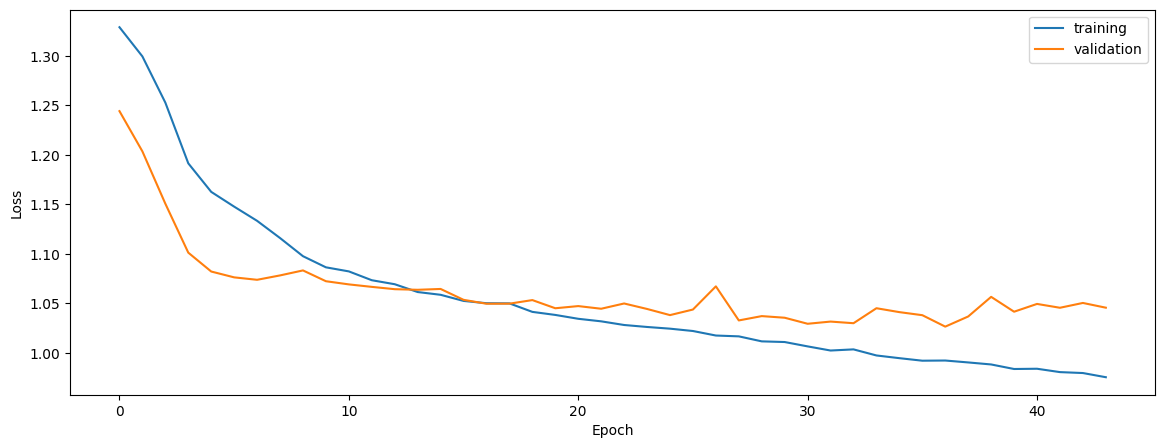

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6487717697163282
0.658872095524957
0.6121242528685485


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

native
0.6487717697163282
0.658872095524957
0.6121242528685485


In [9]:
print('normalized')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.646146094416165
0.6540873583452526
0.6173014970627251


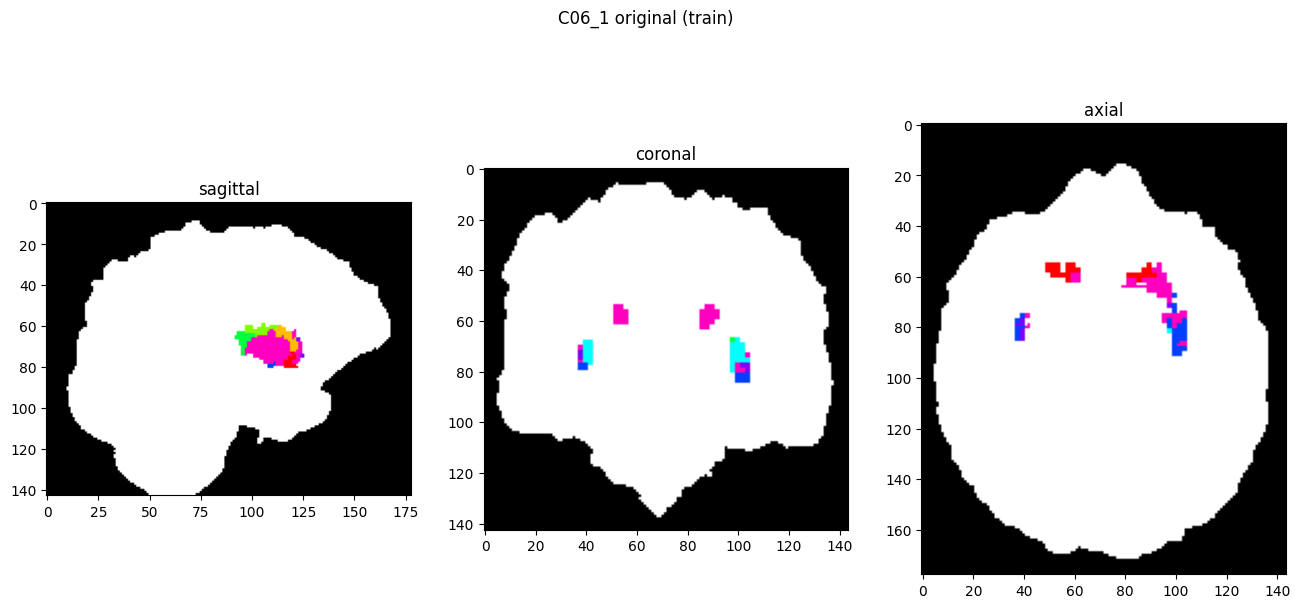

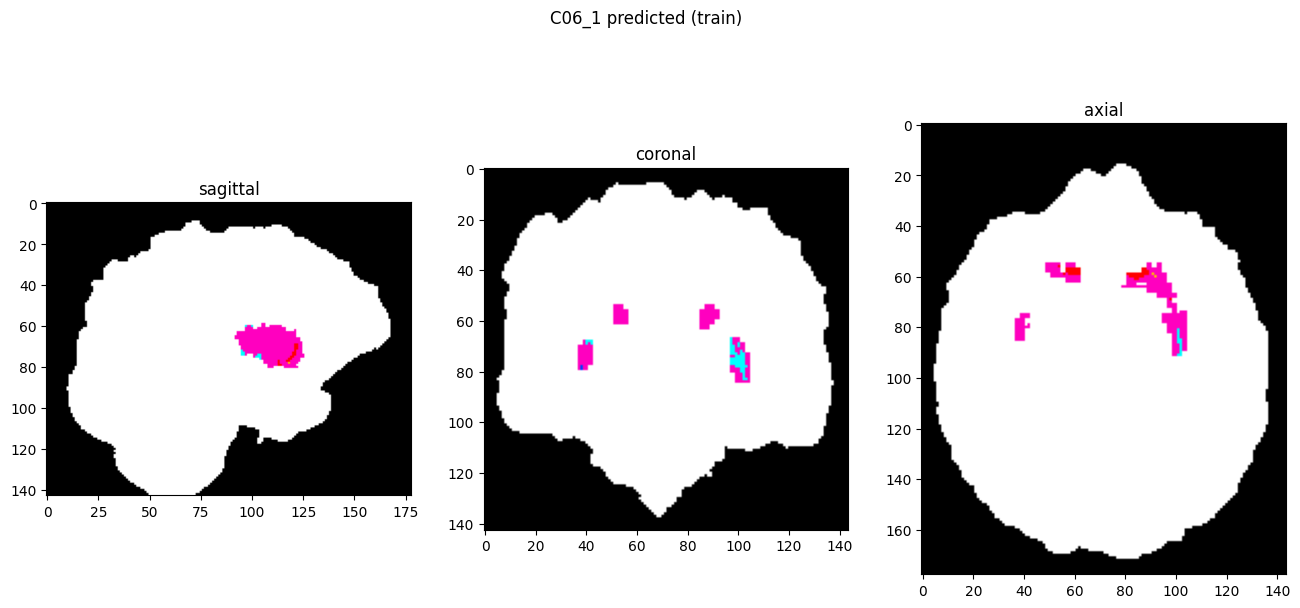

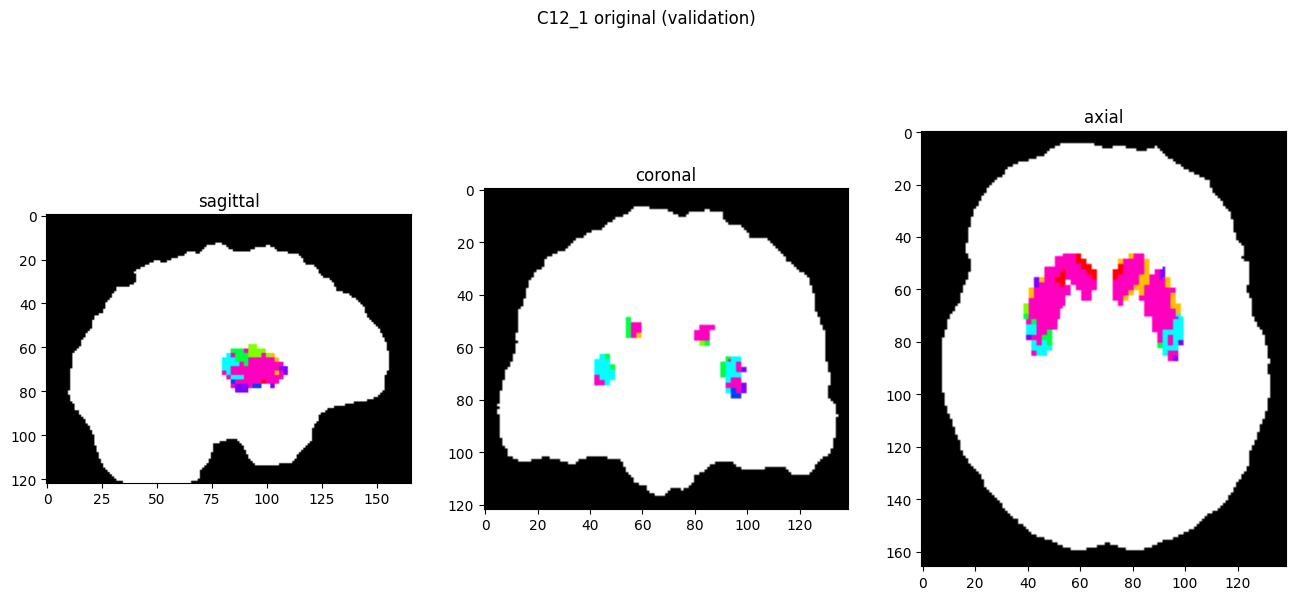

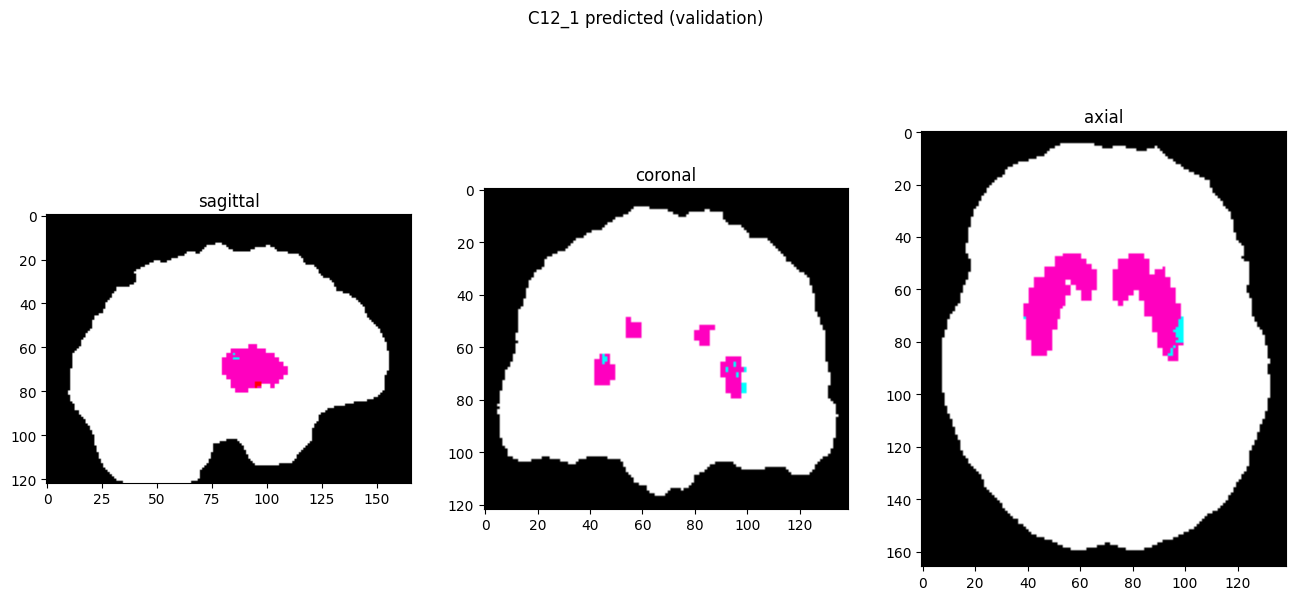

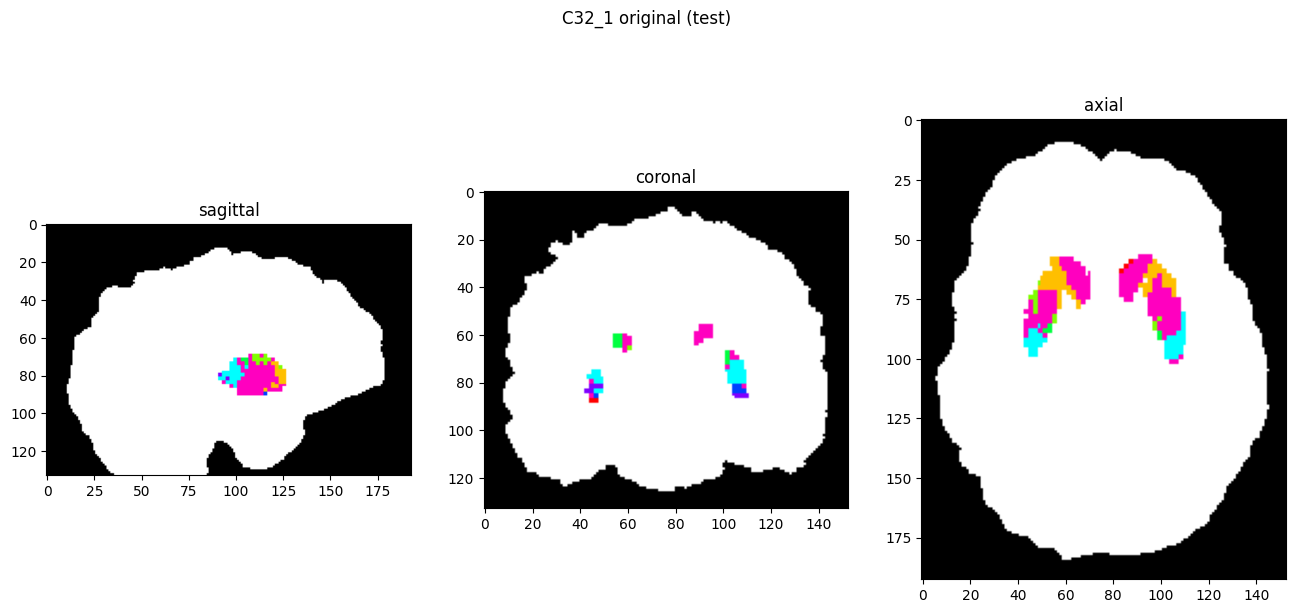

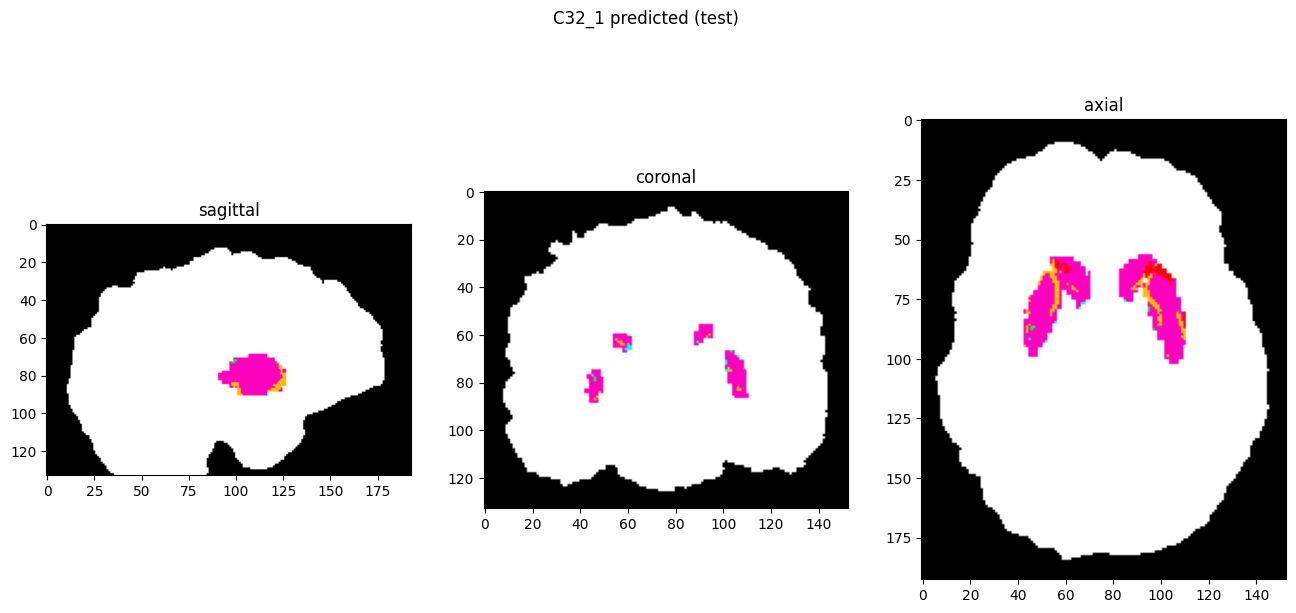

In [10]:
showResults(model, gen, threshold=0)